# Change Impacts and Pressures<img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


# ESA CCI Biomass - Biomass Change

## Change methods

## Background on data layers

This notebooks considers different approaches for quantifying change between above ground biomass generated for 2010 and 2017-2020 (annually) through the ESA CCI Biomass project.

**Land Cover** is the physical and biological cover of the land surface and includes vegetation (managed or semi-natural), water and bare surfaces.  The land cover maps generated through Living Land Management use the legends of the United Nation's Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS).

**Habitats** represent the natural environments in which individual or groups of plant or animal species lives.  

The **C-band AGB retreival** is obtained from time-series of radar data that are acquired almost every day over Wales and indicate relative frequency of wet conditions across the landscape.  

The **L-band AGB retreival** is obtained from time-series of ALOS PALSAR or ALOS-2 PALSAR-2.  

The **Merged layer retreival** is obtained from time-series of radar data that are acquired almost every day over Australia and indicate relative frequency of wet conditions across the landscape.

## Description 

This notebook will demonstrate how to create change maps based on both impact and pressures, taken from Earth observation data or from external data layers.  

For demonstration, the capabiliy of the Digital Earth Australia (DEA) processing witin the framework of the Open Data Cube (ODC) is used.  Through DEA Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retreived or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)


The notebooks take you through the process of accessing the FAO LCCS layer at Level 3 (Basic; 6 classes) and Level 4 (over 100 classes). 

1. Loading land cover classifications (basic and detailed) for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map (representing impacts) based on evidence gathered from Level 4 data.
4. Determining a pressure (in this case, bushfires) from Landsat sensor data.
5. Combining the impacts and pressures to generate a classification according to the notation 'impact (pressure)

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import xarray as xr
import odc.geo.xr
#import rasterio
import geopandas as gpd # Added from WDC

from odc.algo import xr_reproject # From https://docs.dea.ga.gov.au/notebooks/How_to_guides/Reprojecting_data.html

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser  # Added from DEA plotting
from dea_tools.plotting import rgb, plot_wo  # Added from DEA plotting
from matplotlib import colors as mcolours
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking # Added from DEA plotting
from datacube.utils.masking import mask_invalid_data
#from datacube.utils import cog  # Temporarily disabled
from datacube.utils.cog import write_cog
# from display_tools import map_geom, rgb # from WDC - not accessing
from ipyleaflet import GeoData # Added from WDC 
from time import time as time # Added from burn notebook
import datetime as dt # Added from burn notebook
from odc.geo.geom import Geometry
from dea_tools.plotting import rgb

from matplotlib.colors import ListedColormap # Added from WDC
import matplotlib.colors as colors # Added from WDC
from matplotlib import colormaps
import matplotlib.pyplot as plt # Added from WDC
from matplotlib.patches import Patch # Added from WDC

from time import time as time # Added from WDC
import warnings # Added from WDC
warnings.filterwarnings("ignore") # Added from WDC

sys.path.append("../Working")
from landcover import plot_land_cover, lc_colourmap, make_colorbar #added from DEA

#For DEA burn mapping
from datetime import datetime
from datetime import timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39331,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:46459,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/46707/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:42511,


## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [2]:
dc = datacube.Datacube(app="Land_cover_change_mapping")

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Mount Ney in Western Australia, a region which has experienced extensive bushfires and variations in water inundation over the 34 years of observation.  

**NOTE:  You can change the area of interest and also the time range in subsequent user-selected runs of the notebook.

In [3]:
# Mount Ney, Western Australia (120.0,125.0,-35.0,-30.0 [EPSG:4326])
#lat, lon = (-32.5, 122.5)
#lat_buffer = 0.1
#lon_buffer = 0.1

# Leichhardt River
#lat, lon = (-17.6401, 139.8175)
#lat_buffer = 0.1
#lon_buffer = 0.1

# Weipa_all
#lat, lon = (-12.55, 141.90)
#lat_buffer = 0.17
#lon_buffer = 0.20

# Weipa-south
#lat, lon = (-12.67, 141.93)
#lat_buffer = 0.09
#lon_buffer = 0.13

# Hinchinbrook
#lat, lon = (-18.36, 146.20)
#lat_buffer = 0.12
#lon_buffer = 0.12

# Moreton Island 
#lat, lon = (-27.550, 153.46)
#lat_buffer = 0.15
#lon_buffer = 0.12

# Fitzroy
lat, lon = (-23.5134, 150.8100)
lat_buffer = 0.1
lon_buffer = 0.2

#lat, lon = (-32.7181, 122.1832)
#lat_buffer= 0.15
#lon_buffer = 0.15

# Combine central coordinates with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)



In [4]:
# Get colour map for image
# cmap, norm = lc_colourmap('level3_change_colour_scheme') - PREVIOUS USING 
cmap, norm = lc_colourmap('level3_change_colour_scheme')

In [5]:
display_map(x=lon_range, y=lat_range)

# Define dates and/or period of interest


In [6]:
# Set the range of dates for the analysis
time_range = ("2009", "2020")

# CCI Biomass
year2017 = "2017"
year2018 = "2018"
year2019 = "2019"
year2020 = "2020"

In [7]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=[
        "level3",
        "lifeform",
        "vegetation_cover",
        "water_seasonality",
        "water_state",
        "intertidal",
        "water_persistence",
        "bare_gradation",
        "full_classification",
    ],
    resolution=(-25, 25),
    **query
)

2024-07-22 04:39:39,287 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
2024-07-22 04:39:40,497 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


In [8]:
# Gives the dimensions of the area of interest
lc.geobox

GeoBox(1732, 1124, Affine(25.0, 0.0, 1873175.0,
       0.0, -25.0, -2661825.0), PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]])

The following cell will display the area of interest on an interactive map. 
You can zoom in and out to better understand the area you'll be analysing. 

## Biomass Change
Within ESA CCI, four methods for detecting and quantifying change have been proposed.

Method 1: Simple differing in AGB stocks

Method 2: Trend analysis

Method 3: Evidence-based change

Method 4: Space for time

The following describes each of these in turn, giving examples through the Welsh Data Cube

### METHOD 1: Simple differencing in AGB stocks

AGB change as the simple difference in AGB stocks internally between years. The standard deviation of the simple differencing method is provided in the ESA product for the 2017-2018, 2018-2019 and 2019-2020 differences. It reflects the precision of AGB change and is calculated using the square root of the sum of the variances. A quality flag layer is also provided to interpret the reliability of the difference detected by pixel. The quality was determined depending on whether the AGB histograms associated with the pixel at the two epochs were overlapping (in-significant difference) or disjoint (significant difference). The significance of the AGB difference is extracted from the quality flag layer. The simple differencing method is it can maximise accuracy for measuring the amount and direction of change.

#### Load and reproject CCI Biomass data

In [9]:
# Path to CCI Biomass raster file
# (Note all data had been compressed using gdal_translate (gdal_translate -co TILED=YES -co COMPRESS=LZW -tr 10 10 -of GTiff se_2019_Wales_27700.tif se_2019_Wales_27700_LZW.tif; or in QGIS)
# (raster_path = "../Uploads/MtNey_2010_AGBcz.tif")
##  MT Ney AGB2010 = "../Uploads/MtNey_2010_AGBcz.tif"
AGB2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif"
# Load raster, and remove redundant "band" dimension
# (raster = xr.open_rasterio(raster_path).squeeze("band", drop=True))
# raster = xr.open_rasterio(AGB2010).squeeze("band", drop=True)
# raster = xr.open_dataset(AGB2010, engine="rasterio")

In [10]:
AGB2010_prj = rio_slurp_xarray(AGB2010,
                                      lc.geobox,
                                      resampling="nearest")

In [11]:
# Set nodata to `NaN`
AGB2010_prj = mask_invalid_data(AGB2010_prj)

In [12]:
#raster_reprojected.geobox

In [13]:
AGB2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_AGBcz.tif"
# raster = xr.open_rasterio(AGB2017).squeeze("band", drop=True)
AGB2017_prj = rio_slurp_xarray(AGB2017,
                                      lc.geobox,
                                      resampling="nearest")
AGB2017_prj = mask_invalid_data(AGB2017_prj)

In [14]:
AGB2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_AGBcz.tif"
# raster = xr.open_rasterio(AGB2018).squeeze("band", drop=True)
AGB2018_prj = rio_slurp_xarray(AGB2018,
                                      lc.geobox,
                                      resampling="nearest")
AGB2018_prj = mask_invalid_data(AGB2018_prj)

In [15]:
AGB2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_AGBcz.tif"
# raster = xr.open_rasterio(AGB2019).squeeze("band", drop=True)
AGB2019_prj = rio_slurp_xarray(AGB2019,
                                      lc.geobox,
                                      resampling="nearest")
AGB2019_prj = mask_invalid_data(AGB2019_prj)

In [16]:
AGB2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_AGBcz.tif"
# raster = xr.open_rasterio(AGB2020).squeeze("band", drop=True)
AGB2020_prj = rio_slurp_xarray(AGB2020,
                                      lc.geobox,
                                      resampling="nearest")
AGB2020_prj = mask_invalid_data(AGB2020_prj)

In [17]:
SD2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_SDcz.tif"
# raster = xr.open_rasterio(SD2010).squeeze("band", drop=True)
SD2010_prj = rio_slurp_xarray(SD2010,
                                      lc.geobox,
                                      resampling="nearest")
SD2010_prj = mask_invalid_data(SD2010_prj)

In [18]:
SD2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_SDcz.tif"
# raster = xr.open_rasterio(SD2017).squeeze("band", drop=True)
SD2017_prj = rio_slurp_xarray(SD2017,
                                      lc.geobox,
                                      resampling="nearest")
SD2017_prj = mask_invalid_data(SD2017_prj)

In [19]:
SD2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_SDcz.tif"
# raster = xr.open_rasterio(SD2018).squeeze("band", drop=True)
SD2018_prj = rio_slurp_xarray(SD2018,
                                      lc.geobox,
                                      resampling="nearest")
SD2018_prj = mask_invalid_data(SD2018_prj)

In [20]:
SD2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_SDcz.tif"
# raster = xr.open_rasterio(SD2019).squeeze("band", drop=True)
SD2019_prj = rio_slurp_xarray(SD2019,
                                      lc.geobox,
                                      resampling="nearest")
SD2019_prj = mask_invalid_data(SD2019_prj)

In [21]:
SD2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_SDcz.tif"
# raster = xr.open_rasterio(SD2020).squeeze("band", drop=True)
SD2020_prj = rio_slurp_xarray(SD2020,
                                      lc.geobox,
                                      resampling="nearest")
SD2020_prj = mask_invalid_data(SD2020_prj)

In [22]:
del AGB2010, AGB2017, AGB2018, AGB2019, AGB2020, SD2010, SD2017, SD2018, SD2019, SD2020

In [23]:
#AGB2020_prj.geobox

In [24]:
#AGB2020_prj.geobox.resolution

In [25]:
#AGB2020_prj.geobox.extent.boundingbox

In [26]:
AGB = AGB2010_prj.to_dataset(name="AGB2010")
AGB["AGB2017"] = AGB2017_prj
AGB["AGB2018"] = AGB2018_prj
AGB["AGB2019"] = AGB2019_prj
AGB["AGB2020"] = AGB2020_prj

In [27]:
AGB

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 1124, x: 1732)
Coordinates:
  * y            (y) float64 9kB -2.662e+06 -2.662e+06 ... -2.69e+06 -2.69e+06
  * x            (x) float64 14kB 1.873e+06 1.873e+06 ... 1.916e+06 1.916e+06
    spatial_ref  int32 4B 3577
Data variables:
    AGB2010      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2017      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2018      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2019      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2020      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [28]:
del AGB2010_prj, AGB2017_prj, AGB2018_prj, AGB2019_prj, AGB2020_prj

In [29]:
#AGB_fig, axs = plt.subplots(figsize=(10, 4), ncols=2)
#AGB.AGB2010.plot(ax=axs[0])
#AGB.AGB2017.plot(ax=axs[0])
#AGB.AGB2018.plot(ax=axs[2])
#AGB.AGB2019.plot(ax=axs[3])
#AGB.AGB2020.plot(ax=axs[1])

#### Subtract CCI Biomass maps between epochs (one for each year)

In [30]:
diff2010_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2010.fillna(0))
diff2017_2018=(AGB.AGB2018.fillna(0)-AGB.AGB2017.fillna(0))
diff2018_2019=(AGB.AGB2019.fillna(0)-AGB.AGB2018.fillna(0))
diff2019_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2019.fillna(0))
diff2017_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2017.fillna(0))

In [31]:
diff_biomass = diff2010_2020.to_dataset(name="d2010_2020")
diff_biomass["d2017_2018"] = diff2017_2018
diff_biomass["d2018_2019"] = diff2018_2019
diff_biomass["d2019_2020"] = diff2019_2020
diff_biomass["d2017_2020"] = diff2017_2020

In [32]:
del diff2010_2020, diff2017_2018, diff2018_2019, diff2019_2020, diff2017_2020

((1873175.0, 1916475.0, -2689925.0, -2661825.0),
 ([], []),
 ([], []),
 Text(0.5, 1.0, ' '))

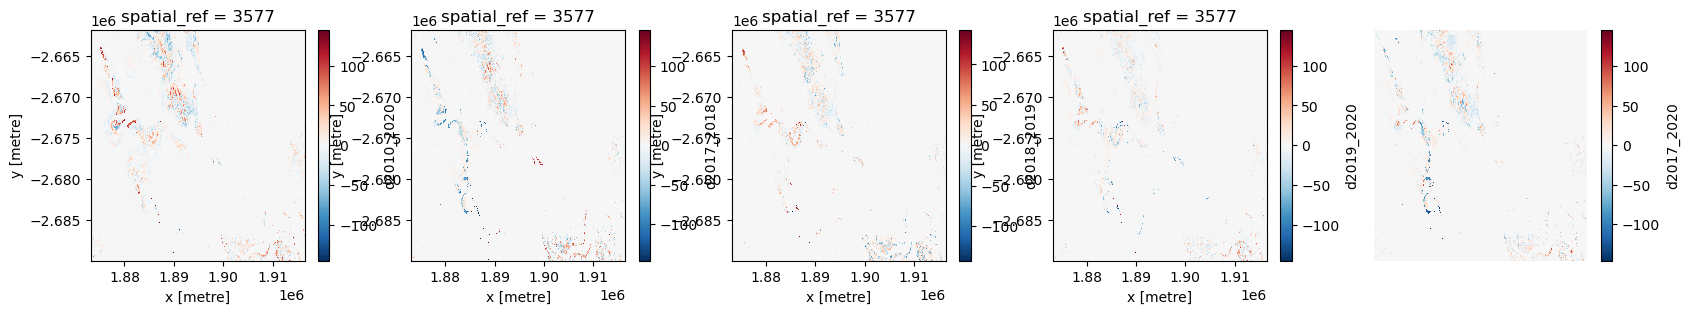

In [33]:
biomassdiff_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
diff_biomass.d2010_2020.plot(ax=axs[0])
diff_biomass.d2017_2018.plot(ax=axs[1])
diff_biomass.d2018_2019.plot(ax=axs[2])
diff_biomass.d2019_2020.plot(ax=axs[3])
diff_biomass.d2017_2020.plot(ax=axs[4])
plt.axis('off'), plt.xticks([]), plt.yticks([]), plt.title(" ")

#### Include the standard deviation (error) for each year

In [34]:
# Save .png to folder
biomassdiff_fig.savefig('./outputs/AGB_subtraction.png')

In [35]:
SD = SD2010_prj.to_dataset(name="SD2010")
SD["SD2017"] = SD2017_prj
SD["SD2018"] = SD2018_prj
SD["SD2019"] = SD2019_prj
SD["SD2020"] = SD2020_prj

2024-07-22 04:39:55,011 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


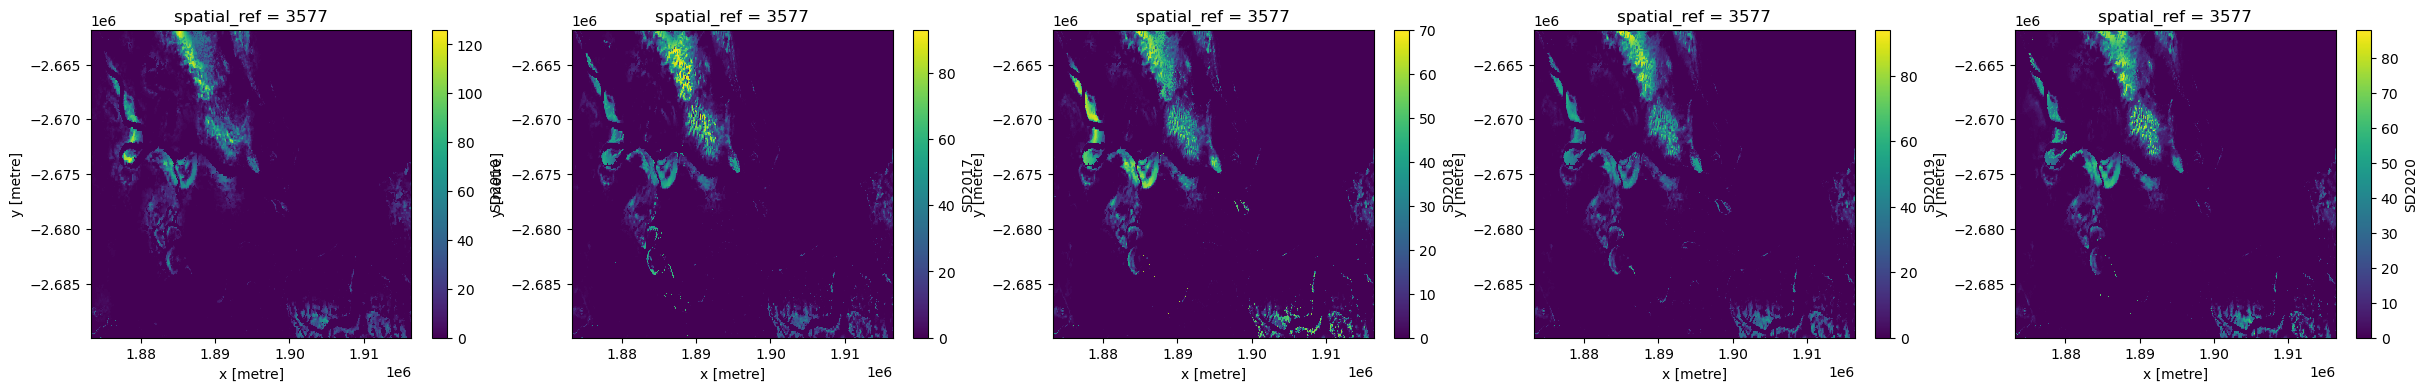

In [36]:
SD_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
SD.SD2010.plot(ax=axs[0])
SD.SD2017.plot(ax=axs[1])
SD.SD2018.plot(ax=axs[2])
SD.SD2019.plot(ax=axs[3])
SD.SD2020.plot(ax=axs[4])

In [37]:
# Save .png to folder
SD_fig.savefig('./outputs/AGB_SD.png')

#### Take the AGB from each year and add and subtract the standard deviation (SD) layer

In [38]:
AGB2010_Min = AGB.AGB2010-SD.SD2010
AGB2010_Max = AGB.AGB2010+SD.SD2010
AGB2017_Min = AGB.AGB2017-SD.SD2017
AGB2017_Max = AGB.AGB2017+SD.SD2017
AGB2018_Min = AGB.AGB2018-SD.SD2018
AGB2018_Max = AGB.AGB2018+SD.SD2018
AGB2019_Min = AGB.AGB2019-SD.SD2019
AGB2019_Max = AGB.AGB2019+SD.SD2019
AGB2020_Min = AGB.AGB2020-SD.SD2020
AGB2020_Max = AGB.AGB2020+SD.SD2020

In [39]:
min_biomass = AGB2010_Min.to_dataset(name="AGB2010_Min")
min_biomass["AGB2017_Min"] = AGB2017_Min
min_biomass["AGB2018_Min"] = AGB2018_Min
min_biomass["AGB2019_Min"] = AGB2019_Min
min_biomass["AGB2020_Min"] = AGB2020_Min

In [40]:
del AGB2010_Min, AGB2017_Min, AGB2018_Min, AGB2019_Min, AGB2020_Min

In [41]:
max_biomass = AGB2010_Max.to_dataset(name="AGB2010_Max")
max_biomass["AGB2017_Max"] = AGB2017_Max
max_biomass["AGB2018_Max"] = AGB2018_Max
max_biomass["AGB2019_Max"] = AGB2019_Max
max_biomass["AGB2020_Max"] = AGB2020_Max

In [42]:
del AGB2010_Max, AGB2017_Max, AGB2018_Max, AGB2019_Max, AGB2020_Max

#### Create a new layer where the change is significant (e.g., cond_decrease = AGB2018_Min gt AGB2019_Max)
Identify where the maximum value of the earlier year (e.g., 2018) is less than the minimum of the later year (e.g., 2019) (INCREASE) and where the minimum value of earlier year is greater than the maximum of later (gain) (i.e., t1max.lt(t2min).or(t1min.gt(t2max))

In [43]:
cond_dec_2010_2020 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2017_2018 = min_biomass.AGB2017_Min.fillna(0) > max_biomass.AGB2018_Max.fillna(0)
cond_dec_2018_2019 = min_biomass.AGB2018_Min.fillna(0) > max_biomass.AGB2019_Max.fillna(0)
cond_dec_2019_2020 = min_biomass.AGB2019_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2017_2020 = min_biomass.AGB2017_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)

In [44]:
cond_inc_2010_2020 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2017_2018 = max_biomass.AGB2017_Max.fillna(0) < min_biomass.AGB2018_Min.fillna(0)
cond_inc_2018_2019 = max_biomass.AGB2018_Max.fillna(0) < min_biomass.AGB2019_Min.fillna(0)
cond_inc_2019_2020 = max_biomass.AGB2019_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2017_2020 = max_biomass.AGB2017_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)

In [45]:
# sc = stockchange
#agb_sc = cond_increase.to_dataset(name="cond_increase") 
#agb_sc["cond_decrease"] = cond_decrease
agb_sc = cond_dec_2010_2020.to_dataset(name="cond_dec_2010_2020") 
agb_sc["cond_dec_2017_2018"] = cond_dec_2017_2018
agb_sc["cond_dec_2018_2019"] = cond_dec_2018_2019 
agb_sc["cond_dec_2019_2020"] = cond_dec_2019_2020 
agb_sc["cond_dec_2017_2020"] = cond_dec_2017_2020 
agb_sc["cond_inc_2010_2020"] = cond_inc_2010_2020
agb_sc["cond_inc_2017_2018"] = cond_inc_2017_2018
agb_sc["cond_inc_2018_2019"] = cond_inc_2018_2019
agb_sc["cond_inc_2019_2020"] = cond_inc_2019_2020
agb_sc["cond_inc_2017_2020"] = cond_inc_2017_2020 

In [46]:
#agb_sc

#### Generate maps of significant decreases or increases in above ground biomass.

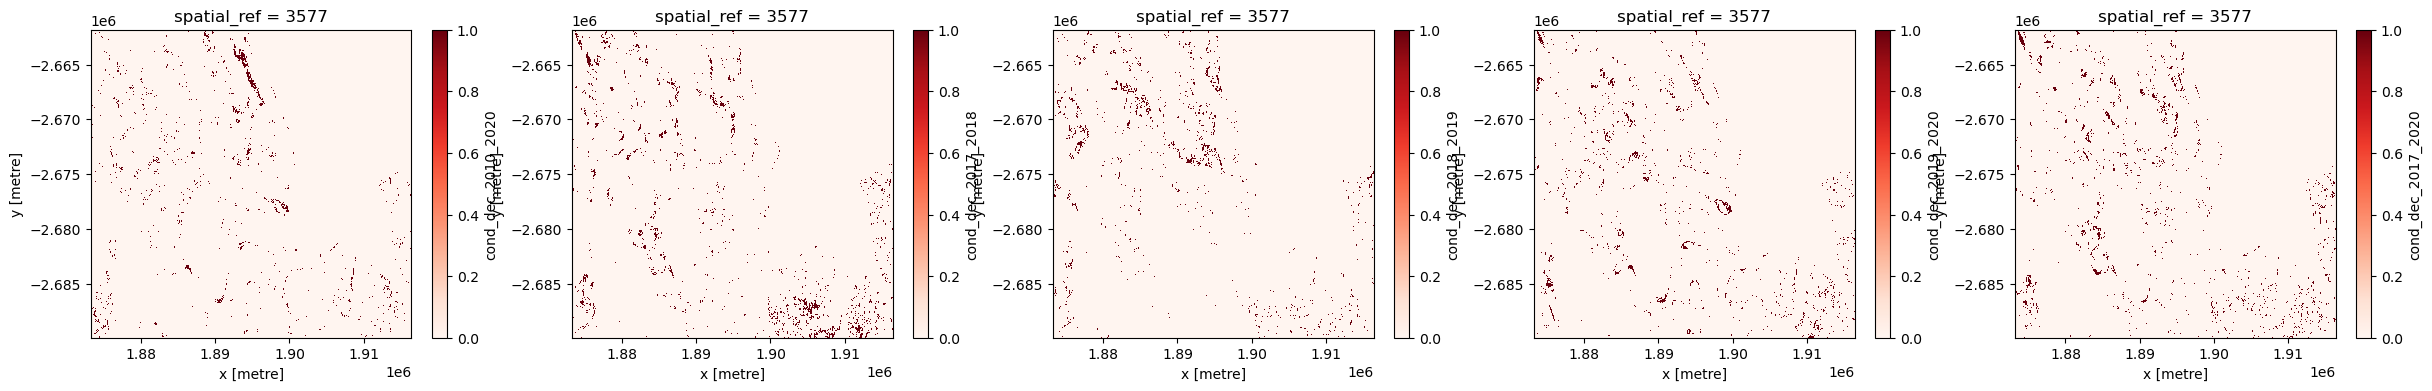

In [47]:
agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
agb_sc.cond_dec_2010_2020.plot(ax=axs[0], cmap='Reds') # Significant decrease
agb_sc.cond_dec_2017_2018.plot(ax=axs[1], cmap='Reds') # Significant decrease
agb_sc.cond_dec_2018_2019.plot(ax=axs[2], cmap='Reds') # Significant decrease
agb_sc.cond_dec_2019_2020.plot(ax=axs[3], cmap='Reds') # Significant decrease
agb_sc.cond_dec_2017_2020.plot(ax=axs[4], cmap='Reds') # Significant decrease

In [48]:
# Save .png to folder
agb_sc_fig.savefig('./outputs/Significant_agb_loss.png')

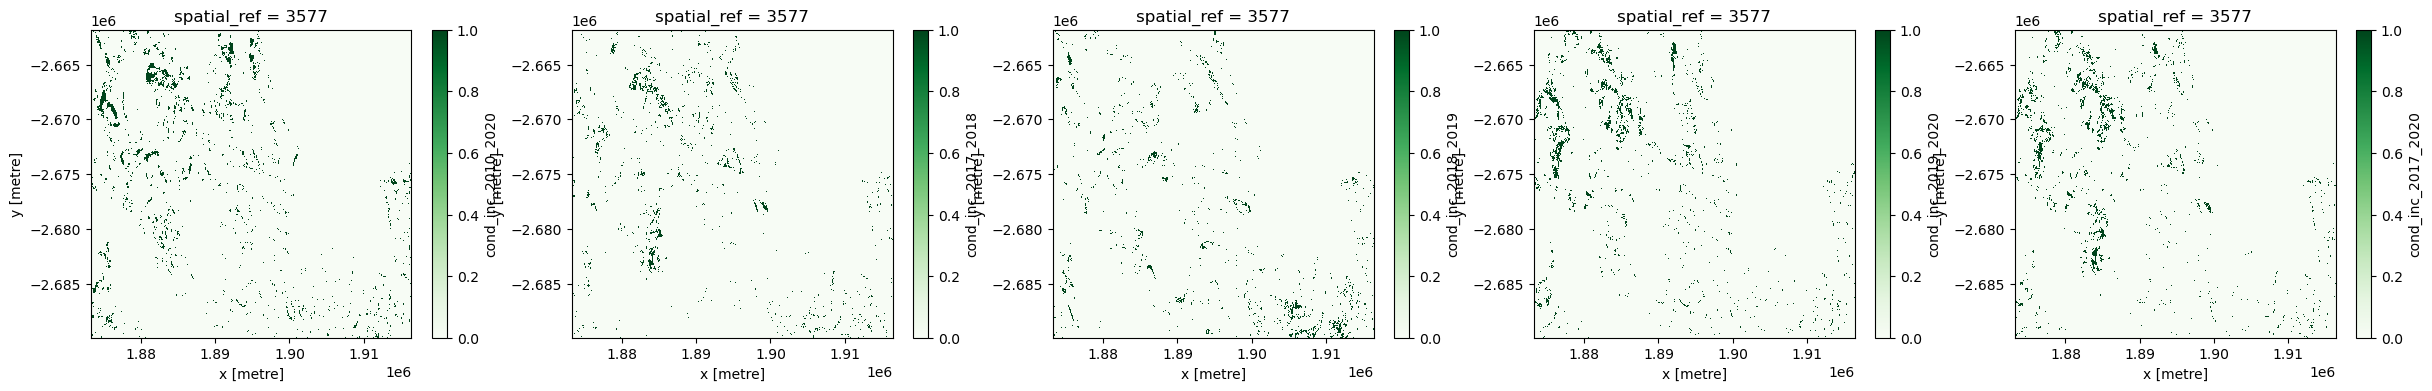

In [49]:
agb_sc_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
agb_sc.cond_inc_2010_2020.plot(ax=axs[0], cmap='Greens') # Significant increase
agb_sc.cond_inc_2017_2018.plot(ax=axs[1], cmap='Greens') # Significant increase
agb_sc.cond_inc_2018_2019.plot(ax=axs[2], cmap='Greens') # Significant increase
agb_sc.cond_inc_2019_2020.plot(ax=axs[3], cmap='Greens') # Significant increase
agb_sc.cond_inc_2017_2020.plot(ax=axs[4], cmap='Greens') # Significant increase

In [50]:
# Save habitats map to your folder
agb_sc_fig.savefig('./outputs/Significant_agb_gain.png')

In [51]:
#agb_stockchange_fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
#agb_stockchange.cond_increase.plot(ax=axs[0], cmap='Reds') # Significant decrease
#agb_stockchange.cond_decrease.plot(ax=axs[1], cmap='Greens') # Significant increase

In [52]:
del cond_dec_2019_2020, cond_dec_2017_2020, cond_inc_2010_2020, cond_inc_2017_2018, cond_inc_2018_2019, cond_inc_2019_2020,  cond_inc_2017_2020  

In [53]:
AGB

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 1124, x: 1732)
Coordinates:
  * y            (y) float64 9kB -2.662e+06 -2.662e+06 ... -2.69e+06 -2.69e+06
  * x            (x) float64 14kB 1.873e+06 1.873e+06 ... 1.916e+06 1.916e+06
    spatial_ref  int32 4B 3577
Data variables:
    AGB2010      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2017      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2018      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2019      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2020      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [54]:
-12.5843

-12.5843

#### Plotting

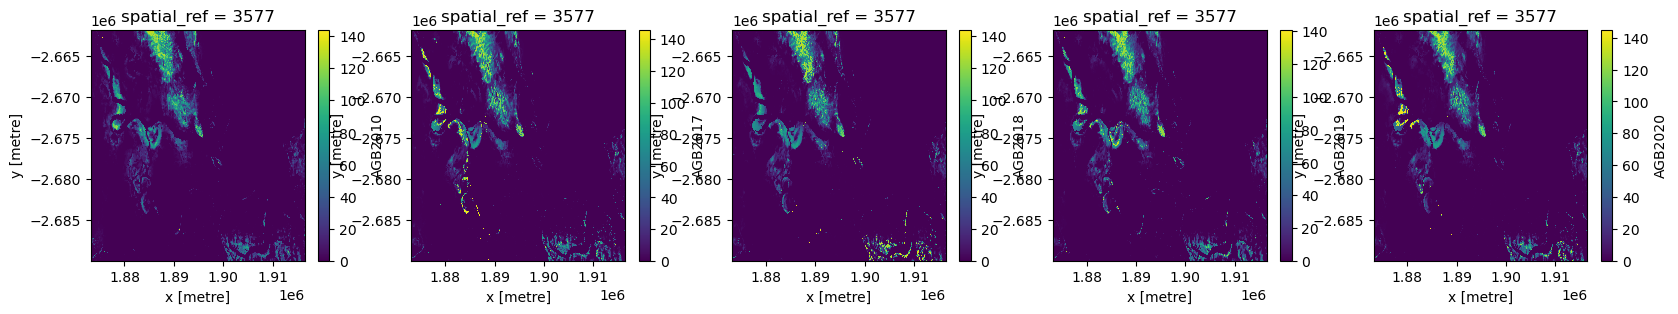

In [55]:
AGB_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
AGB.AGB2010.plot(ax=axs[0])
AGB.AGB2017.plot(ax=axs[1])
AGB.AGB2018.plot(ax=axs[2])
AGB.AGB2019.plot(ax=axs[3])
AGB.AGB2020.plot(ax=axs[4])

## METHOD 2:  Trend analysis of AGB stocks

In [56]:
AGB

<xarray.Dataset> Size: 39MB
Dimensions:      (y: 1124, x: 1732)
Coordinates:
  * y            (y) float64 9kB -2.662e+06 -2.662e+06 ... -2.69e+06 -2.69e+06
  * x            (x) float64 14kB 1.873e+06 1.873e+06 ... 1.916e+06 1.916e+06
    spatial_ref  int32 4B 3577
Data variables:
    AGB2010      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2017      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2018      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2019      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AGB2020      (y, x) float32 8MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

To identify monotonic trends in AGB (i.e. either an increase, decrease or no change), a nonseasonal Mann-Kendall non-parameteric test (Kendall, 1938; Mann, 1945) was used, with this being suitable for detecing change detection over time-series observations. The Mann-Kendall statistic is calculated as the sum of signs of all the pairs of observations. The speed of change was estimated using the Theil-Sen slope estimator (Theil, 195; Sen, 1968), which is the median slope from all the pairs of observations. This method is robust to outliers, but sensitive to autocorrelation and ties in the time series. Significance of the trend over 2017-2020 is calculated as z-statistic divided by its standard deviation (two-sided test).  

In [57]:
# List DEA Fractional Cover products available in DEA
#dc_products = dc.list_products()
#dc_products.loc[['ga_ls_fc_3']]

In [58]:
#pv: The fractional cover of green vegetation
#npv: The fractional cover of non-green vegetation
#bs: The fractional cover of bare soil
#ue: The fractional cover unmixing error

#dc_measurements = dc.list_measurements()
#dc_measurements.loc[['ga_ls_fc_3']]

In [59]:
# Load DEA Fractional Cover data from the datacube
#fc = dc.load(product='ga_ls_fc_3',
#             measurements=['bs', 'pv', 'npv', 'ue'],
#             output_crs='EPSG:32755',
#             resolution=(-30, 30),
#             group_by='solar_day',
#            **query)

In [60]:
# Replace all nodata values with `NaN`
#fc = masking.mask_invalid_data(fc)

In [61]:
# Load DEA Water Observations data from the datacube
#wo = dc.load(product='ga_ls_wo_3',
#             group_by='solar_day',
#             fuse_func=wofs_fuser,
#             like=fc)

# Plot the loaded water observations
#plot_wo(wo.water, col='time', size=5)

# Keeping only dry, non-cloudy pixels
#wo_mask = masking.make_mask(wo.water, dry=True)
#wo_mask.plot(col='time', size=5)

# Set any unclear or wet pixel to `NaN`
#fc_masked = fc.where(wo_mask)

# Plot the masked fractional cover data
#rgb(fc_masked, bands=['bs', 'pv', 'npv'], col='time')

# Calculate the percent of nodata pixels in each observation
#percent_nodata = fc_masked.pv.isnull().mean(dim=['x', 'y'])

# Use this to filter to observations with less than 50% nodata
#fc_masked = fc_masked.sel(time=percent_nodata < 0.5)

# The data now contains only three observations
#fc_masked

In [62]:
# Calculate average fractional cover for `bs`, `pv` and `npv` over time
#fc_through_time = fc_masked[['pv', 'npv', 'bs']].mean(dim=['x', 'y'])

# Plot the changing proportions as a line graph
#fc_through_time.to_array().plot.line(hue='variable', size=5)
#plt.title('Fractional cover over time')
#plt.ylabel('Percent cover (%)');

## METHOD 3: Evidence-based change

Evidence-based change considers the different impacts and driving pressures, with these defined in a Global Change Taxonomy (GCT) developed by Lucas et al. (2000). The GCT lists 77 impact and 144 pressure categories that give 248 'impact (pressure)' categories when combined.   Evidence requirements for both impacts and the pressures are suggested. For forests, impacts include dieback, damage and/or losses and gains in extent or amount.  For pressures, these may vary considerably and over different periods of time, with examples being burning, pathogens and deforestation.

## 3.1  Observed change
The observed change considers conversions (i.e., changes in extent of the Level 3 classes) and modification (i.e., the level 3 class remains the same but there are changes in categorical (e.g., lifeform) or continuous (e.g., water hydroperiod) environmental descriptors.  

#### Numerical key for changes in overarching environmental descriptors
01: CTV greening 				111111 - cover  
02: CTV browning 				111111 - cover  
03: CAV wetting  				123123 - moisture  
04: CAV drying   				123123 - moisture  
05: NTV extent loss 			112 to ALL  
06: NTV extent gain				ALL to 112  
07: NTV herbaceous increase		112112 – cover (non-woody)  
08: NTV herbaceous decrease		112112 – cover (non-woody)  
09: NTV woody increase			112112 – cover and woody fraction  
10: NTV woody decrease			112112 – cover and woody fraction  
11: NAV extent gain				124 to ALL 
12: NAV extent loss				ALL to 124  
13: NAV herbaceous vegetation increase	124124	- cover (non-woody)  
14: NAV herbaceous vegetation decreases	124124	- cover (non-woody)  
15: NAV woody vegetation increase		124124	- cover and woody fraction  
16: NAV woody vegetation decreases		124124	- cover and woody fraction  
17: AS extent gain				ALL to 215  
18: AS extent loss				215 to ALL  
19: NWAW extent gain 			ALL to 220  
20: NWAW extent loss			220 to ALL  
21: NWAW persistence increase	220220 – water persistence  
22: NWAW Persistence decrease	220220 – water persistence
23: Conversion of NTV to NAV
24: Conversion of NAV to NTV
25: Conversion of CTV to CAV
26: Conversion of CAV to CTV
27: NTV loss to urban
28: NAV loss to urban

Note that 27 and 28 avoids the duplication of 112 to 215 in 12 and also in 17.

### Plot the land cover over the time-series (level 3 and lifeform)

## Load and view the Environmental Descriptors (EDs)
The following cell will load what are termed the Environmental Descriptors (EDs) used to construct the Basic (Level 3) and subsequently the Detailed (Level 4) land cover maps for the `lat_range`, `lon_range` and `time_range` defined for your area of interest.

You can view each of these layers using the  `plot_land_cover()` function.

** Note:  You can run one, several or all of these to view the appropriate product.

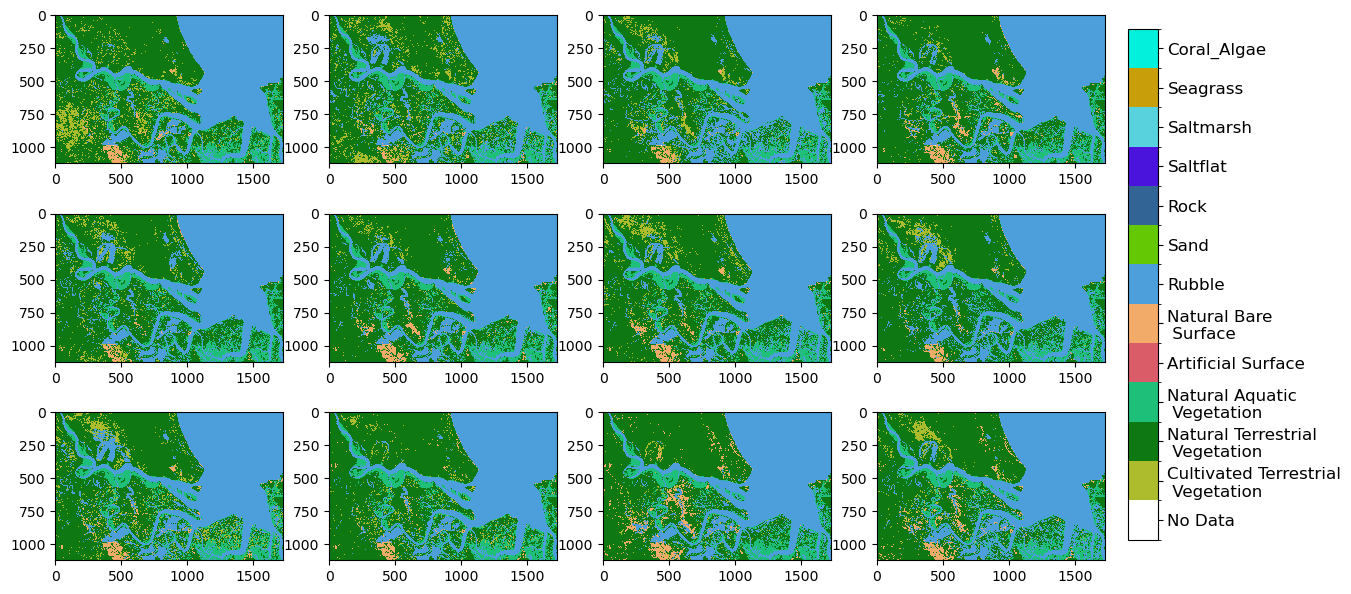

In [63]:
plot_land_cover(lc.level3)

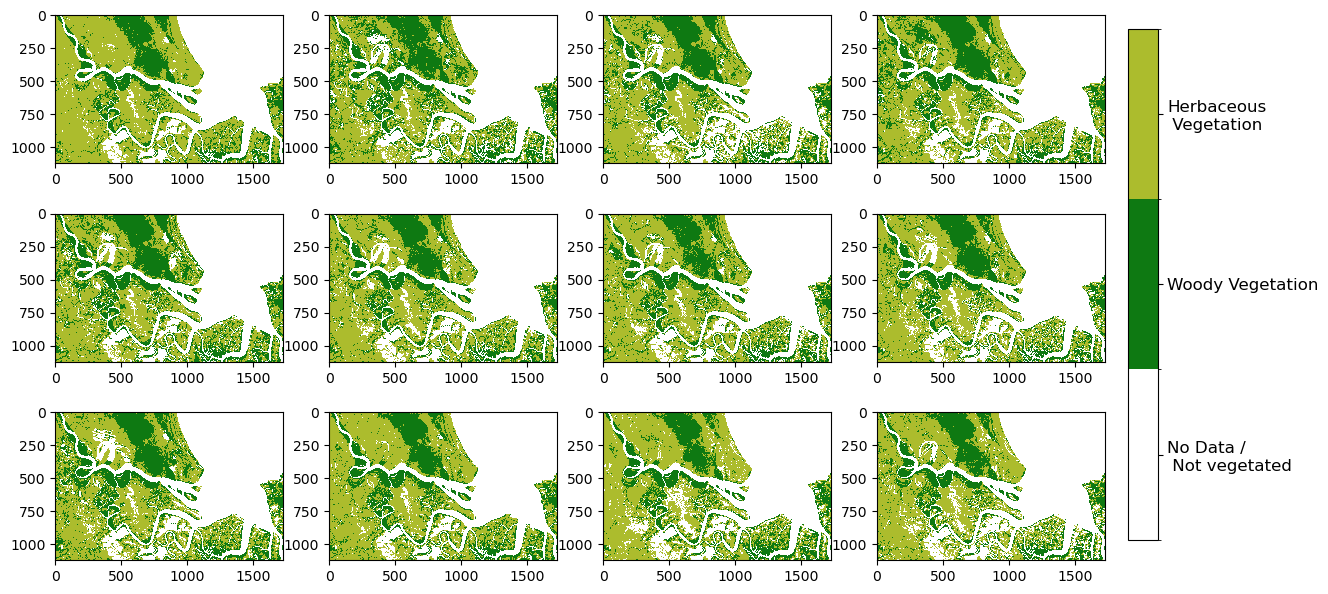

In [64]:
plot_land_cover(lc.lifeform)

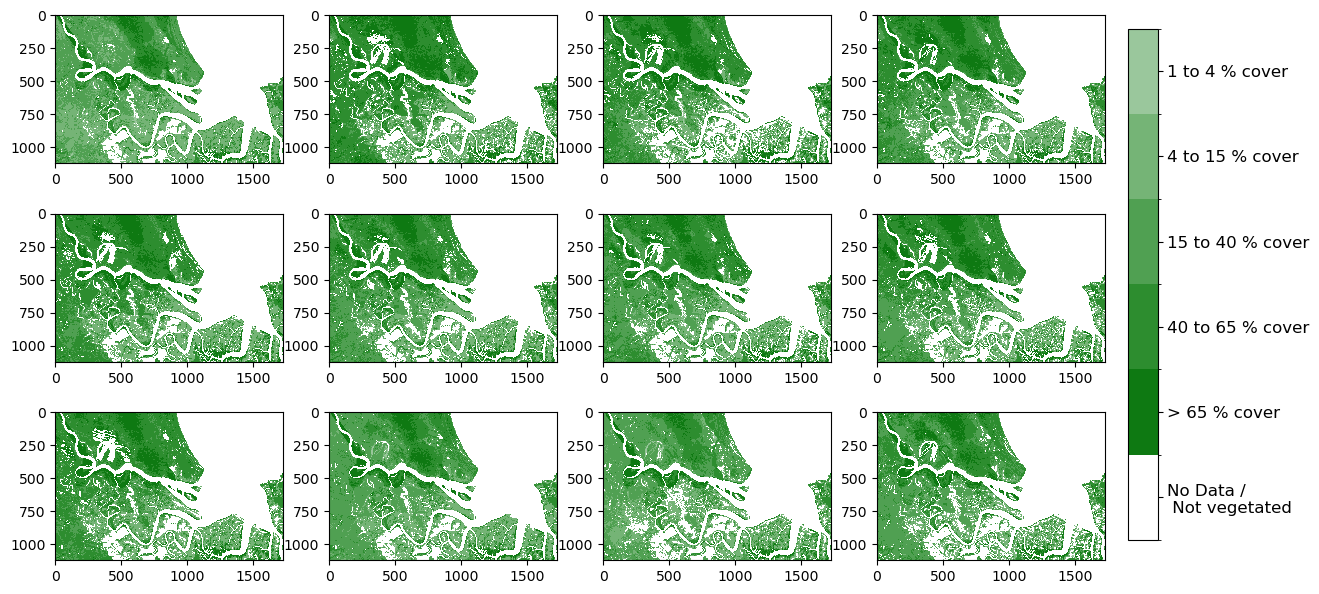

In [65]:
plot_land_cover(lc.vegetation_cover)

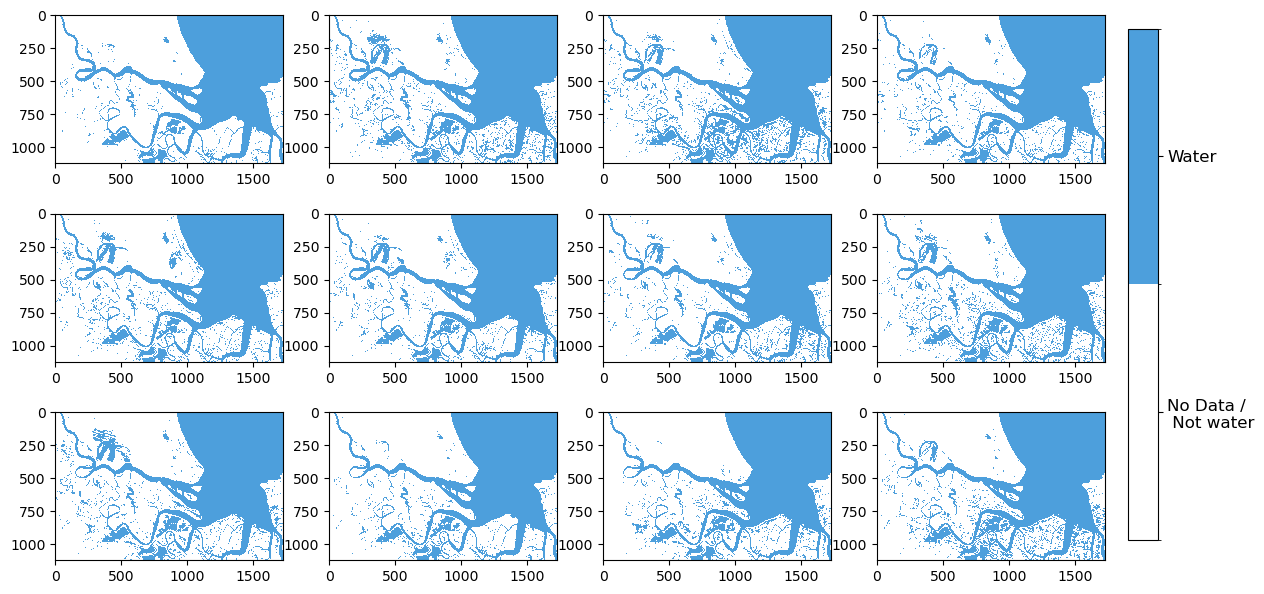

In [66]:
plot_land_cover(lc.water_state)

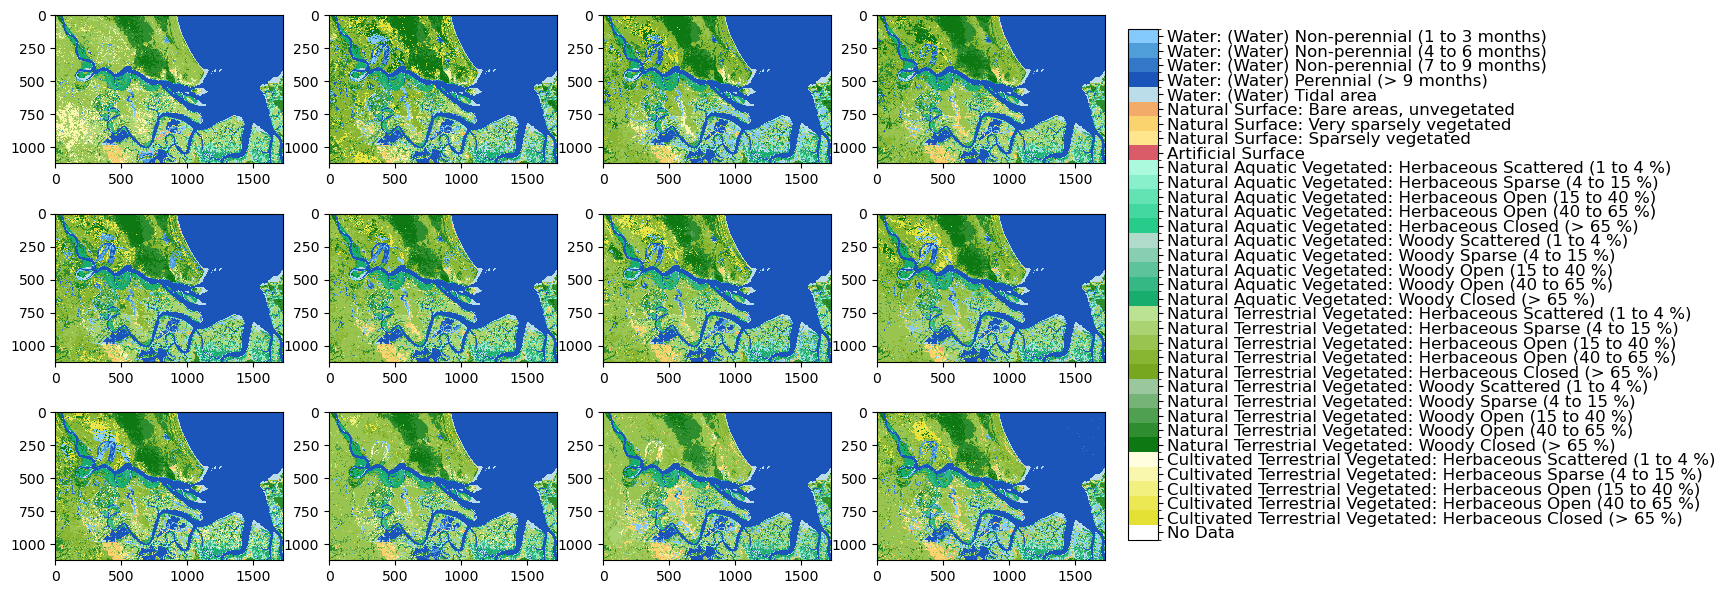

In [67]:
plot_land_cover(lc.full_classification)

In [68]:
lc.geobox

GeoBox(1732, 1124, Affine(25.0, 0.0, 1873175.0,
       0.0, -25.0, -2661825.0), PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]])

### Level 3 change maps 

A first step towards developing a globally relevant and standardized taxonomy and framework for consistently describing land cover change was to establish the transition matrix between observed broad land cover classes (i.e., OEDs).  This stage was developed and is illustrated using the FAO LCCS given the dichotomous and then hierarchical modular structure of this taxonomy.  Between-class transitions and within-class changes can be identified by comparing these OEDs (i.e., the FAO LCCS Level 3 classes; 8 in total) between any two time-separated periods (i.e., T1 and T2), leading to 64 potential change categories; 56 on the off-diagonals and 8 on the on-diagonals.  

** Note:  There are 6 classes in the case of Australia as there are limited cultivated aquatic landscapes, and artificial and natural water are merged.

In the following steps, you will compare the earliest and latest Level 3 layers in selected time-series.

#### Select the start and end dates for comparisons of enviromental descriptors 
(e.g., Level 3, lifeform, vegetation cover, water state and level 4 (full classification))

#### ALL LEVEL 3 CHANGES

### NO CHANGE

#### Areas of no change from 2010 [0] to 2020 [-1 or 4]

In [69]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = False

# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
    
level_3 = lc.level3[0].drop_vars("time") 

# Create a new Xarray.DataArray
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [70]:
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

#### Areas of no change from 2017 [1] to 2018 [2]

In [71]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)
ignore_no_change = False # Mark if you want to ignore no change
# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [72]:
# Create a new Xarray.DataArray
obs_change_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [73]:
obs_change_l3["l3_2017_2018"] = obs_change_l3_2017_2018
del obs_change_l3_2017_2018

#### Areas of no change from 2018 [2] to 2019 [3]

In [74]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [75]:
# Create a new Xarray.DataArray
obs_change_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [76]:
obs_change_l3["l3_2018_2019"] = obs_change_l3_2018_2019
del obs_change_l3_2018_2019

#### Areas of no change from 2019 [3] to 2020 [4 or -1]

In [77]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [78]:
# Create a new Xarray.DataArray
obs_change_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [79]:
obs_change_l3["l3_2019_2020"] = obs_change_l3_2019_2020
del obs_change_l3_2019_2020

#### Areas of no change from 2017 [1] to 2020 [4 or -1]

In [80]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [81]:
# Create a new Xarray.DataArray
obs_change_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [82]:
obs_change_l3["l3_2017_2020"] = obs_change_l3_2017_2020
del obs_change_l3_2017_2020

In [83]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_scheme')

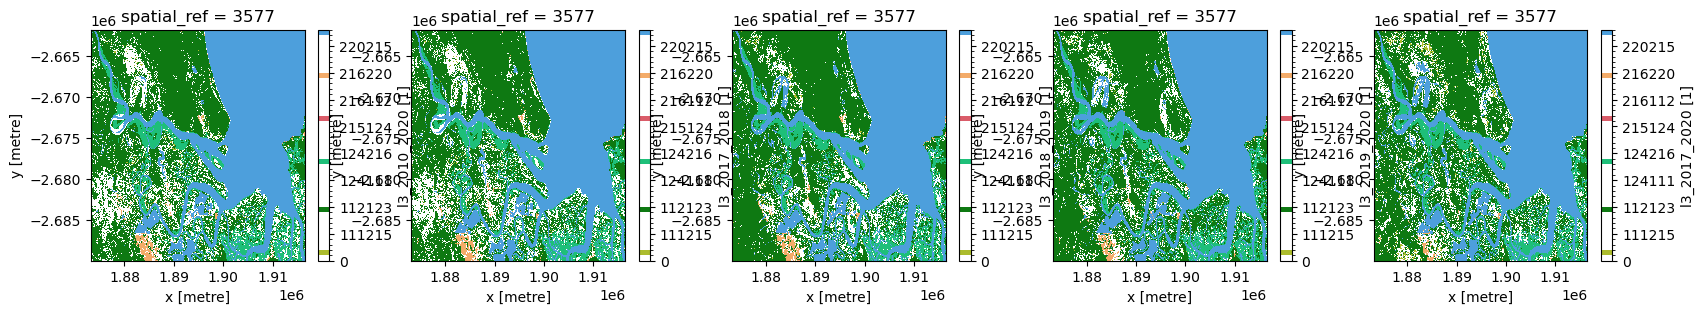

In [84]:
obs_change_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_change_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm)
obs_change_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) 
obs_change_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm)
obs_change_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm)
obs_change_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) 

In [85]:
# Save .png to folder
obs_change_l3_fig.savefig('./outputs/Level 3 no change.png')

### GAINS

#### Change (gains) in Level 3 from 2010 [0] to 2020 [4 or -1]

In [86]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [87]:
level_3 = lc.level3[0].drop_vars("time")

In [88]:
# Create a new Xarray.DataArray
obs_gain_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [89]:
obs_gain_l3 = obs_gain_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_gain_l3_2010_2020

#### Change (gains) from 2017 [1] to 2018 [2]

In [90]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = True

In [91]:
# Mark if you want to ignore no change
ignore_no_change = True

In [92]:
# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [93]:
level_3 = lc.level3[0].drop_vars("time")

In [94]:
# Create a new Xarray.DataArray
obs_gain_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [95]:
obs_gain_l3["l3_2017_2018"] = obs_gain_l3_2017_2018
del obs_gain_l3_2017_2018

#### Change (gains) from 2018 [2] to 2019 [3]

In [96]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [97]:
# Create a new Xarray.DataArray
obs_gain_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [98]:
obs_gain_l3["l3_2018_2019"] = obs_gain_l3_2018_2019
del obs_gain_l3_2018_2019

#### Change (gains)( from 2019 [3] to 2020 [4 or -1]

In [99]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [100]:
# Create a new Xarray.DataArray
obs_gain_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [101]:
obs_gain_l3["l3_2019_2020"] = obs_gain_l3_2019_2020
del obs_gain_l3_2019_2020

#### Change (gains) from 2017 [1] to 2020 [4 or -1]

In [102]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [103]:
# Create a new Xarray.DataArray
obs_gain_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [104]:
obs_gain_l3["l3_2017_2020"] = obs_gain_l3_2017_2020
del obs_gain_l3_2017_2020

### Plot Level 3 gains

In [105]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_gain')

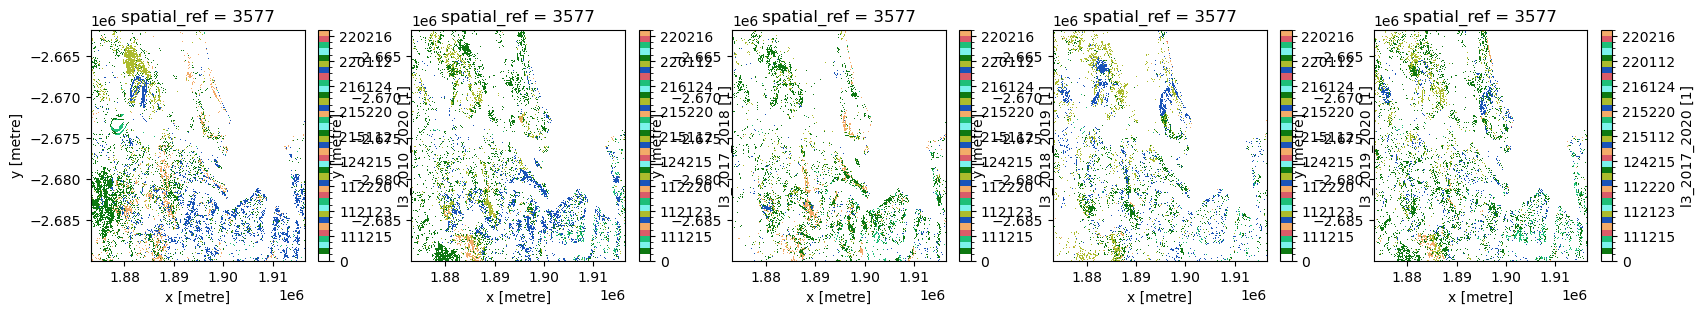

In [106]:
obs_gain_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_gain_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [107]:
# Save .png to folder
obs_gain_l3_fig.savefig('./outputs/Level 3 gains.png')

In [108]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_gain_l3["l3_2010_2020"],
          fname='obs_gain_l3_2010_2020.tif',
          overwrite=True)

PosixPath('obs_gain_l3_2010_2020.tif')

### LOSSES

#### Identify change (loss) in Level 3 from 2010 [0] to 2020 [-1 or 4]

In [109]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
# (Note changing to (end * 1000) + start
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
#level_3 = lc.level3[0].drop_vars("time")

In [110]:
# Create a new Xarray.DataArray
obs_loss_l3_2010_2020= xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed losses",
    attrs=level_3.attrs,
    fastpath=False,
)

In [111]:
obs_loss_l3 = obs_loss_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_loss_l3_2010_2020

In [112]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_loss')

In [113]:
#obs_loss_l3["l3_2017_2020"] = obs_loss_l3

In [114]:
#obs_loss_l3_fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
#obs_loss_l3.l3_2017_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease

#### Change from 2017 [1] to 2018 [2]

In [115]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [116]:
# Create a new Xarray.DataArray
obs_loss_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [117]:
obs_loss_l3["l3_2017_2018"] = obs_loss_l3_2017_2018
del obs_loss_l3_2017_2018

#### Change from 2018 [2] to 2019 [3]

In [118]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [119]:
# Create a new Xarray.DataArray
obs_loss_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [120]:
obs_loss_l3["l3_2018_2019"] = obs_loss_l3_2018_2019
del obs_loss_l3_2018_2019

#### Change from 2019 [3] to 2020 [4]

In [121]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [122]:
# Create a new Xarray.DataArray
obs_loss_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [123]:
obs_loss_l3["l3_2019_2020"] = obs_loss_l3_2019_2020
del obs_loss_l3_2019_2020

#### Change from 2017 [1] to 2020 [4]

In [124]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [125]:
# Create a new Xarray.DataArray
obs_loss_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

#### Plot Level 3 losses

In [126]:
obs_loss_l3["l3_2017_2020"] = obs_loss_l3_2017_2020
del obs_loss_l3_2017_2020

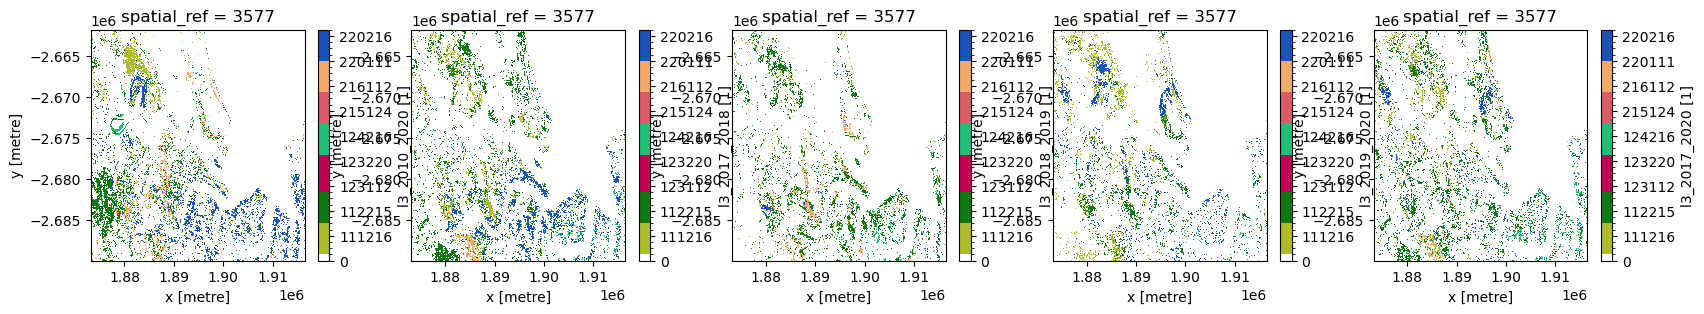

In [127]:
obs_loss_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_loss_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [128]:
# Save .png to folder
obs_loss_l3_fig.savefig('./outputs/Level 3 losses.png')

In [129]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_loss_l3["l3_2010_2020"],
          fname='obs_loss_l3_2010_2020.tif',
          overwrite=True)

PosixPath('obs_loss_l3_2010_2020.tif')

## Lifeform change maps

#### Change in Lifeform from 2010 [0] to 2020 [4 or -1]

In [130]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[0].astype(np.int32)
end = lc.lifeform[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[0].drop_vars("time")

In [131]:
# Create a new Xarray.DataArray
obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [132]:
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")
del obs_change_lf_2010_2020

#### Change from 2017 [1] to 2018 [2]

In [133]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[1].astype(np.int32)
end = lc.lifeform[2].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[1].drop_vars("time")

In [134]:
# Create a new Xarray.DataArray
obs_change_lf_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [135]:
obs_change_lf["lf_2017_2018"] = obs_change_lf_2017_2018
del obs_change_lf_2017_2018

#### Change from 2018 [2] to 2019 [3]

In [136]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[2].astype(np.int32)
end = lc.lifeform[3].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[2].drop_vars("time")

In [137]:
# Create a new Xarray.DataArray
obs_change_lf_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [138]:
obs_change_lf["lf_2018_2019"] = obs_change_lf_2018_2019
del obs_change_lf_2018_2019

#### Change from 2019 [3] to 2020 [4]

In [139]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[3].astype(np.int32)
end = lc.lifeform[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[3].drop_vars("time")

In [140]:
# Create a new Xarray.DataArray
obs_change_lf_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [141]:
obs_change_lf["lf_2019_2020"] = obs_change_lf_2019_2020
del obs_change_lf_2019_2020

#### Change from 2017 [1] to 2020 [4]

In [142]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[1].astype(np.int32)
end = lc.lifeform[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[4].drop_vars("time")

In [143]:
# Create a new Xarray.DataArray
obs_change_lf_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [144]:
obs_change_lf["lf_2017_2020"] = obs_change_lf_2017_2020
del obs_change_lf_2017_2020

#### Plot lifeform change

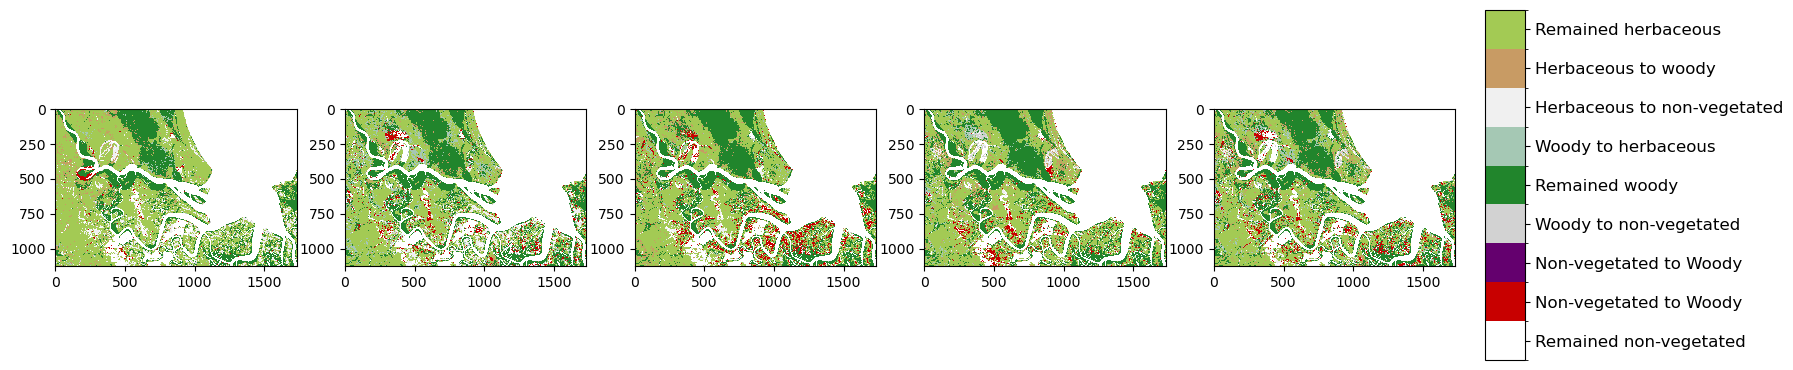

In [145]:
# Create figure with subplot and set size in inches
fig, axs = plt.subplots(figsize=(20, 5), ncols=5)
# fig.set_size_inches(7, 7)

make_colorbar(fig, axs[2], measurement='lfchange_colour_scheme')
cmap, norm = lc_colourmap('lfchange_colour_scheme')

# Plot change data
axs[0].imshow(obs_change_lf.lf_2010_2020, cmap=cmap, norm=norm, interpolation="nearest")
axs[1].imshow(obs_change_lf.lf_2017_2018, cmap=cmap, norm=norm, interpolation="nearest")
axs[2].imshow(obs_change_lf.lf_2018_2019, cmap=cmap, norm=norm, interpolation="nearest")
axs[3].imshow(obs_change_lf.lf_2019_2020, cmap=cmap, norm=norm, interpolation="nearest")
axs[4].imshow(obs_change_lf.lf_2017_2020, cmap=cmap, norm=norm, interpolation="nearest")

#####  Another way of plotting (but slower)
#obs_change_lf_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
#obs_change_lf.lf_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [146]:
# Save .png to folder
fig.savefig('./outputs/lifeform change.png')
del fig

## The Global Change Taxonomy and Evidence-Based Change Framework

This notebooks introduces a globally relevant and standardized taxonomy and framework for consistently describing land cover change based on evidence is presented, which makes use of structured land cover taxonomies and is underpinned by the Driver-Pressure-State-Impact-Response (DPSIR) framework.  

The Global Change Taxonomy currently lists 248 classes based on the notation ‘impact (pressure)’, with this encompassing the consequence of observed change and associated reason(s), and uses scale-independent terms that factor in time. 

Evidence for different impacts is gathered through temporal comparison (e.g., days, decades apart) of land cover classes constructed and described from Environmental Descriptors (EDs; state indicators) with pre-defined measurement units (e.g., m, %) or categories (e.g., species type).  

Evidence for pressures, whether abiotic, biotic or human-influenced, is similarly accumulated, but EDs often differ from those used to determine impacts.  Each impact and pressure term is defined separately, allowing flexible combination into ‘impact (pressure)’ categories, and all are listed in an openly accessible glossary to ensure consistent use and common understanding.   

The taxonomy and framework are globally relevant and can reference EDs quantified on the ground, retrieved/classified remotely (from ground-based, airborne or spaceborne sensors) or predicted through modelling. By providing capacity to more consistently describe change processes – including land degradation, desertification and ecosystem restoration - the overall framework addresses a wide and diverse range of local to international needs including those relevant to policy, socioeconomics and land management.  Actions in response to impacts and pressures and monitoring towards targets are also supported to assist future planning, including impact mitigation actions. 

## Evidence for impacts
There are 77 impact and 144 pressure categories and each of these can be assigned a unique number (i.e., 1-77 for impacts; 1-44 for pressures).  By then multiplying the codes, with a weighting of 1000 for impacts (i.e., ip_code = (impact * 1000) + pressure, a unique number for the impacts and pressures combined (248 in total) is given.   For example:

6144  = impact 6 pressure 144
61044 = impact 61 and pressure 44

A dictionary of impacts and pressures is as below, noting that these are selectively combined (see Lucas et al., (2022):

dict_impact = {1: Accretion,
        2: B,
        3: C}
dict_pressures = {1: A
        2: B,
        3: C}
dict_impact_pressures = {1: 1,
        2: 111112,
        3: 77144}

## Impact No. 44: Vegetation amount (loss)
Changes in the amount of vegetation is generally a modification (noting though that conversions (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place) and results in a change generally in continous variables such as biomass, canopy cover and/or height (among others).  Here, we assume that the land cover has stayed the same.

In [147]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)

Im44_2010_2020xa = xr.DataArray(
    data=Im44_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2010_2020xa = Im44_2010_2020xa

In [148]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2017_2018 = np.where(
    (
        ((obs_change_l3.l3_2017_2018 == 111111) & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112112)  & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 123123)  & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 124124) & (obs_change_lf.lf_2017_2018 == 11)  & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
    ),
    1,
    0,
)
Im44_2017_2018xa = xr.DataArray(
    data=Im44_2017_2018,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_22017_2018xa = Im44_2017_2018xa

In [149]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2018_2019 = np.where(
    (
        ((obs_change_l3.l3_2018_2019 == 111111) & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112112)  & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 123123)  & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 124124) & (obs_change_lf.lf_2018_2019 == 11)  & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
    ),
    1,
    0,
)
Im44_2018_2019xa = xr.DataArray(
    data=Im44_2018_2019,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2018_2019xa = Im44_2018_2019xa

In [150]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2019_2020 = np.where(
    (
        ((obs_change_l3.l3_2019_2020 == 111111) & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112112)  & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 123123)  & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 124124) & (obs_change_lf.lf_2019_2020 == 11)  & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
    ),
    1,
    0,
)
Im44_2019_2020xa = xr.DataArray(
    data=Im44_2019_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2019_2020xa = Im44_2019_2020xa

In [151]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2017_2020 = np.where(
    (
        ((obs_change_l3.l3_2017_2020 == 111111) & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112112)  & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 123123)  & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 124124) & (obs_change_lf.lf_2017_2020 == 11)  & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
    ),
    1,
    0,
)
Im44_2017_2020xa = xr.DataArray(
    data=Im44_2017_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im44_2017_2020xa = Im44_2017_2020xa

In [152]:
Im44 = Im44_2010_2020xa.to_dataset(name="Im44_2010_2020")
Im44["Im44_2017_2018"] = Im44_2017_2018xa
Im44["Im44_2018_2019"] = Im44_2018_2019xa
Im44["Im44_2019_2020"] = Im44_2019_2020xa
Im44["Im44_2017_2020"] = Im44_2017_2020xa
#del Im44_2010_2020, Im44_2017_2018xa, Im44_2018_2019xa, Im44_2019_2020xa, Im44_2017_2020xa

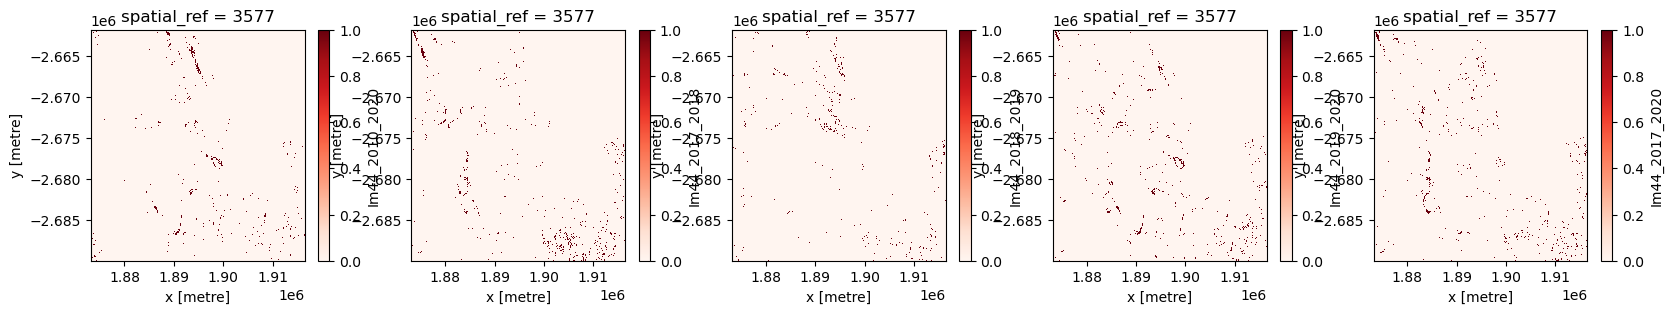

In [153]:
Im44_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Im44.Im44_2010_2020.plot(ax=axs[0], cmap='Reds')
Im44.Im44_2017_2018.plot(ax=axs[1], cmap='Reds')
Im44.Im44_2018_2019.plot(ax=axs[2], cmap='Reds')
Im44.Im44_2019_2020.plot(ax=axs[3], cmap='Reds')
Im44.Im44_2017_2020.plot(ax=axs[4], cmap='Reds')

In [154]:
# Save .png to folder
Im44_fig.savefig('./outputs/Im44.png')

## Impact No. 45: Vegetation extent (loss)
Changes in the extent of vegetation is generally a conversion (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place). Here, the change observed is from one land cover to another.

In [155]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 112111) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112215) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112216) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112220) & (diff_biomass.d2010_2020 < 0) & (agb_sc.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)
Im45_2010_2020xa = xr.DataArray(
    data=Im45_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="45: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2010_2020xa = Im45_2010_2020xa

In [156]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2017_2018 = np.where(
    (
        ((obs_change_l3.l3_2017_2018 == 112111) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112111) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112216) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112220) & (diff_biomass.d2017_2018 < 0) & (agb_sc.cond_dec_2017_2018 == 1))
    ),
    1,
    0,
)
Im45_2017_2018xa = xr.DataArray(
    data=Im45_2017_2018,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="45: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2017_2018xa = Im45_2017_2018xa

In [157]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2018_2019 = np.where(
    (
        ((obs_change_l3.l3_2018_2019 == 112111) & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112111)  & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112216)  & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112220) & (diff_biomass.d2018_2019 < 0) & (agb_sc.cond_dec_2018_2019 == 1))
    ),
    1,
    0,
)
Im45_2018_2019xa = xr.DataArray(
    data=Im45_2018_2019,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="45: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2018_2019xa = Im45_2018_2019xa

In [158]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2019_2020 = np.where(
    (
        ((obs_change_l3.l3_2019_2020 == 112111) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112111) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112216) & (diff_biomass.d2019_2020 < 0) & (agb_sc.cond_dec_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112220) & (diff_biomass.d2019_2020 <0) & (agb_sc.cond_dec_2019_2020 == 1))
    ),
    1,
    0,
)
Im45_2019_2020xa = xr.DataArray(
    data=Im45_2019_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="45: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2019_2020xa = Im45_2019_2020xa

In [159]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2017_2020 = np.where(
    (
        ((obs_change_l3.l3_2017_2020 == 112111) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112111) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112216) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112220) & (diff_biomass.d2017_2020 < 0) & (agb_sc.cond_dec_2017_2020 == 1))
    ),
    1,
    0,
)
Im45_2017_2020xa = xr.DataArray(
    data=Im45_2017_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="45: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im45_2017_2020xa = Im45_2017_2020xa

In [160]:
Im45 = Im45_2010_2020xa.to_dataset(name="Im45_2010_2020")
Im45["Im45_2017_2018"] = Im45_2017_2018xa
Im45["Im45_2018_2019"] = Im45_2018_2019xa
Im45["Im45_2019_2020"] = Im45_2019_2020xa
Im45["Im45_2017_2020"] = Im45_2017_2020xa
#del Im45_2010_2020, Im45_2017_2018xa, Im45_2018_2019xa, Im45_2019_2020xa, Im45_2017_2020xa

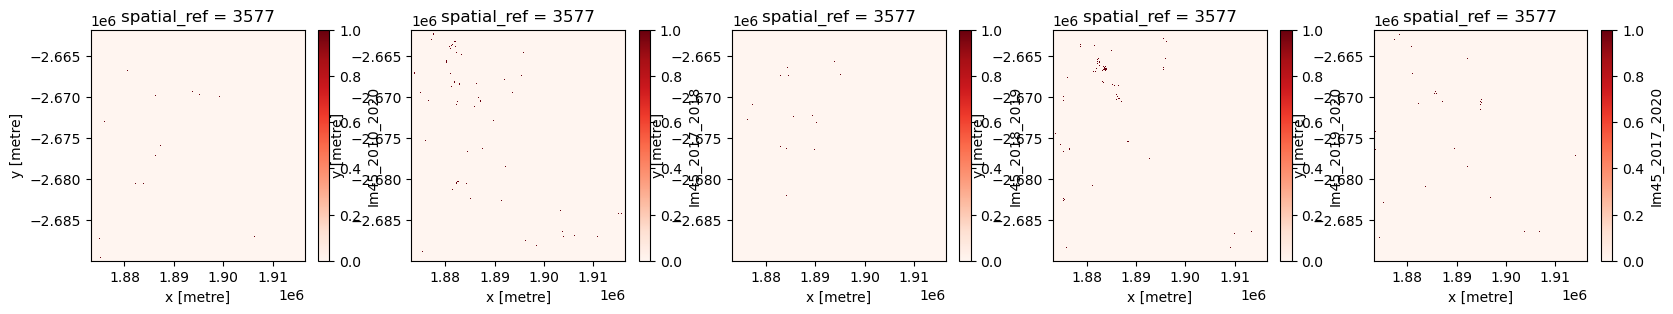

In [161]:
Im45_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Im45.Im45_2010_2020.plot(ax=axs[0], cmap='Reds')
Im45.Im45_2017_2018.plot(ax=axs[1], cmap='Reds')
Im45.Im45_2018_2019.plot(ax=axs[2], cmap='Reds')
Im45.Im45_2019_2020.plot(ax=axs[3], cmap='Reds')
Im45.Im45_2017_2020.plot(ax=axs[4], cmap='Reds')

In [162]:
# Save .png to folder
Im45_fig.savefig('./outputs/Im45.png')

## Impact No. 46: Vegetation amount (gain)
Changes in the extent of vegetation are generally a conversion (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place). Here, the change observed is from one land cover to another.

In [163]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
    ),
    1,
    0,
)

Im46_2010_2020xa = xr.DataArray(
    data=Im46_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="46: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2010_2020xa = Im46_2010_2020xa

In [164]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2017_2018 = np.where(
    (
        ((obs_change_l3.l3_2017_2018 == 111111) & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112112)  & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 123123)  & (obs_change_lf.lf_2017_2018 == 11) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 124124) & (obs_change_lf.lf_2017_2018 == 11)  & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
    ),
    1,
    0,
)
Im46_2017_2018xa = xr.DataArray(
    data=Im46_2017_2018,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="46: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_22017_2018xa = Im46_2017_2018xa

In [165]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2018_2019 = np.where(
    (
        ((obs_change_l3.l3_2018_2019 == 111111) & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112112)  & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 123123)  & (obs_change_lf.lf_2018_2019 == 11) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 124124) & (obs_change_lf.lf_2018_2019 == 11)  & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
    ),
    1,
    0,
)
Im46_2018_2019xa = xr.DataArray(
    data=Im46_2018_2019,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="46: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2018_2019xa = Im46_2018_2019xa

In [166]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2019_2020 = np.where(
    (
        ((obs_change_l3.l3_2019_2020 == 111111) & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112112)  & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 123123)  & (obs_change_lf.lf_2019_2020 == 11) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 124124) & (obs_change_lf.lf_2019_2020 == 11)  & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
    ),
    1,
    0,
)
Im46_2019_2020xa = xr.DataArray(
    data=Im46_2019_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="46: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2019_2020xa = Im46_2019_2020xa

In [167]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2017_2020 = np.where(
    (
        ((obs_change_l3.l3_2017_2020 == 111111) & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112112)  & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 123123)  & (obs_change_lf.lf_2017_2020 == 11) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 124124) & (obs_change_lf.lf_2017_2020 == 11)  & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
    ),
    1,
    0,
)
Im46_2017_2020xa = xr.DataArray(
    data=Im46_2017_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="44: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im46_2017_2020xa = Im46_2017_2020xa

In [168]:
Im46 = Im46_2010_2020xa.to_dataset(name="Im46_2010_2020")
Im46["Im46_2017_2018"] = Im46_2017_2018xa
Im46["Im46_2018_2019"] = Im46_2018_2019xa
Im46["Im46_2019_2020"] = Im46_2019_2020xa
Im46["Im46_2017_2020"] = Im46_2017_2020xa
#del Im46_2010_2020, Im46_2017_2018xa, Im46_2018_2019xa, Im46_2019_2020xa, Im46_2017_2020xa

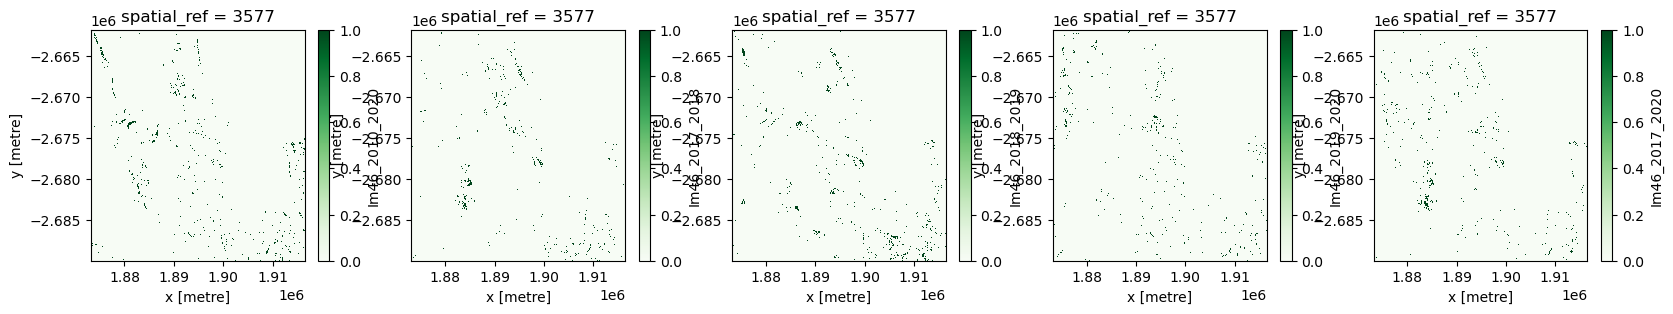

In [169]:
Im46_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Im46.Im46_2010_2020.plot(ax=axs[0], cmap='Greens')
Im46.Im46_2017_2018.plot(ax=axs[1], cmap='Greens')
Im46.Im46_2018_2019.plot(ax=axs[2], cmap='Greens')
Im46.Im46_2019_2020.plot(ax=axs[3], cmap='Greens')
Im46.Im46_2017_2020.plot(ax=axs[4], cmap='Greens')

In [170]:
# Save .png to folder
Im46_fig.savefig('./outputs/Im46.png')

## No. 47: Vegetation extent (gain)
Changes in the amount of vegetation is generally a modification (noting though that conversions (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place) and results in a change generally in continous variables such as biomass, canopy cover and/or height (among others).  Here, we assume that the land cover has stayed the same.

In [171]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 220112) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | (((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 21)) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 215112) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 216112) & (diff_biomass.d2010_2020 > 0) & (agb_sc.cond_inc_2010_2020 == 1))
    ),
    1,
    0,
)
Im47_2010_2020xa = xr.DataArray(
    data=Im47_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="47: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2010_2020xa = Im47_2010_2020xa

In [172]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2017_2018 = np.where(
    (
        ((obs_change_l3.l3_2017_2018 == 220112) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 112112) & (obs_change_lf.lf_2017_2018 == 21) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 215112) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
        | ((obs_change_l3.l3_2017_2018 == 216112) & (diff_biomass.d2017_2018 > 0) & (agb_sc.cond_inc_2017_2018 == 1))
    ),
    1,
    0,
)
Im47_2017_2018xa = xr.DataArray(
    data=Im47_2017_2018,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="47: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2017_2018xa = Im47_2017_2018xa

In [173]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2018_2019 = np.where(
    (
        ((obs_change_l3.l3_2018_2019 == 220112)& (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_dec_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 112112) & (obs_change_lf.lf_2018_2019 == 21) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 215112) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
        | ((obs_change_l3.l3_2018_2019 == 216112) & (diff_biomass.d2018_2019 > 0) & (agb_sc.cond_inc_2018_2019 == 1))
    ),
    1,
    0,
)
Im47_2018_2019xa = xr.DataArray(
    data=Im47_2018_2019,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="47: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2018_2019xa = Im47_2018_2019xa

In [174]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2019_2020 = np.where(
    (
        ((obs_change_l3.l3_2019_2020 == 220112) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 112112) & (obs_change_lf.lf_2019_2020 == 21) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 215112) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
        | ((obs_change_l3.l3_2019_2020 == 216112) & (diff_biomass.d2019_2020 > 0) & (agb_sc.cond_inc_2019_2020 == 1))
    ),
    1,
    0,
)
Im47_2019_2020xa = xr.DataArray(
    data=Im47_2019_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="47: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2019_2020xa = Im47_2019_2020xa

In [175]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2017_2020 = np.where(
    (
        ((obs_change_l3.l3_2017_2020 == 220112) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 112112) & (obs_change_lf.lf_2017_2020 == 21) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 215112) & (diff_biomass.d2017_2020 > 0) & (agb_sc.cond_inc_2017_2020 == 1))
        | ((obs_change_l3.l3_2017_2020 == 216112) & (diff_biomass.d2017_2020 >0) & (agb_sc.cond_inc_2017_2020 == 1))
    ),
    1,
    0,
)
Im47_2017_2020xa = xr.DataArray(
    data=Im47_2017_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="47: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im47_2017_2020xa = Im47_2017_2020xa

In [176]:
Im47 = Im47_2010_2020xa.to_dataset(name="Im47_2010_2020")
Im47["Im47_2017_2018"] = Im47_2017_2018xa
Im47["Im47_2018_2019"] = Im47_2018_2019xa
Im47["Im47_2019_2020"] = Im47_2019_2020xa
Im47["Im47_2017_2020"] = Im47_2017_2020xa
#del Im47_2010_2020, Im47_2017_2018xa, Im47_2018_2019xa, Im47_2019_2020xa, Im47_2017_2020xa

In [ ]:
Im47_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Im47.Im47_2010_2020.plot(ax=axs[0], cmap='Greens')
Im47.Im47_2017_2018.plot(ax=axs[1], cmap='Greens')
Im47.Im47_2018_2019.plot(ax=axs[2], cmap='Greens')
Im47.Im47_2019_2020.plot(ax=axs[3], cmap='Greens')
Im47.Im47_2017_2020.plot(ax=axs[4], cmap='Greens')

In [ ]:
# Save .png to folder
Im47_fig.savefig('./outputs/Im47.png')

### Generate summary maps of impacts

In [ ]:
Impact_Comp_2010_2020 = (Im44_2010_2020xa * 44).to_dataset(name="Im44")
Impact_Comp_2010_2020 ["Im45"] = Im45_2010_2020xa * 45
Impact_Comp_2010_2020 ["Im46"] = Im46_2010_2020xa * 46
Impact_Comp_2010_2020 ["Im47"] = Im47_2010_2020xa * 47
Impact_Comp_2010_2020 ["Sum"] = ((Im44_2010_2020xa * 44) + (Im45_2010_2020xa * 45)  + (Im47_2010_2020xa * 46) + (Im47_2010_2020xa * 47))

In [ ]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
#cmap, norm = lc_colourmap('Impacts_colour_scheme')
cmap = ListedColormap(["white", "darkviolet", "red", "deepskyblue", "lawngreen"])
norm = colors.BoundaryNorm([0, 1, 44, 45, 46, 47], 6)

In [ ]:
Impact_Comp_2010_2020_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Impact_Comp_2010_2020.Im44.plot(ax=axs[0], cmap=cmap)
Impact_Comp_2010_2020.Im45.plot(ax=axs[1], cmap=cmap)
Impact_Comp_2010_2020.Im46.plot(ax=axs[2], cmap=cmap)
Impact_Comp_2010_2020.Im47.plot(ax=axs[3], cmap=cmap)
Impact_Comp_2010_2020.Sum.plot(ax=axs[4], cmap=cmap)

In [ ]:
# Save .png to folder
Impact_Comp_2010_2020_fig.savefig('./outputs/ImpactComp_2010_2020.png')

In [ ]:
Impact_Comp_2017_2018 = (Im44_2017_2018xa * 44).to_dataset(name="Im44")
Impact_Comp_2017_2018 ["Im45"] = Im45_2010_2020xa * 45
Impact_Comp_2017_2018 ["Im46"] = Im46_2010_2020xa * 46
Impact_Comp_2017_2018 ["Im47"] = Im47_2010_2020xa * 47
Impact_Comp_2017_2018 ["Sum"] = ((Im44_2017_2018xa * 44) + (Im45_2017_2018xa * 45)  + (Im46_2017_2018xa * 46) + (Im47_2017_2018xa * 47))

In [ ]:
Impact_Comp_2017_2018_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Impact_Comp_2017_2018.Im44.plot(ax=axs[0], cmap=cmap)
Impact_Comp_2017_2018.Im45.plot(ax=axs[1], cmap=cmap)
Impact_Comp_2017_2018.Im46.plot(ax=axs[2], cmap=cmap)
Impact_Comp_2017_2018.Im47.plot(ax=axs[3], cmap=cmap)
Impact_Comp_2017_2018.Sum.plot(ax=axs[4], cmap=cmap)

In [ ]:
# Save .png to folder
Impact_Comp_2017_2018_fig.savefig('./outputs/ImpactComp_2017_2018.png')

In [ ]:
Impact_Comp_2018_2019 = (Im44_2018_2019xa * 44).to_dataset(name="Im44")
Impact_Comp_2018_2019 ["Im45"] = Im45_2018_2019xa * 45
Impact_Comp_2018_2019 ["Im46"] = Im46_2018_2019xa * 46
Impact_Comp_2018_2019 ["Im47"] = Im47_2018_2019xa * 47
Impact_Comp_2018_2019 ["Sum"] = ((Im44_2018_2019xa * 44) + (Im45_2018_2019xa * 45)  + (Im47_2018_2019xa * 46) + (Im47_2018_2019xa * 47))

In [ ]:
Impact_Comp_2018_2019_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Impact_Comp_2018_2019.Im44.plot(ax=axs[0], cmap=cmap)
Impact_Comp_2018_2019.Im45.plot(ax=axs[1], cmap=cmap)
Impact_Comp_2018_2019.Im46.plot(ax=axs[2], cmap=cmap)
Impact_Comp_2018_2019.Im47.plot(ax=axs[3], cmap=cmap)
Impact_Comp_2018_2019.Sum.plot(ax=axs[4], cmap=cmap)

In [ ]:
# Save .png to folder
Impact_Comp_2018_2019_fig.savefig('./outputs/ImpactComp_2018_2019.png')

In [ ]:
Impact_Comp_2019_2020 = (Im44_2019_2020xa * 44).to_dataset(name="Im44")
Impact_Comp_2019_2020 ["Im45"] = Im45_2010_2020xa * 45
Impact_Comp_2019_2020 ["Im46"] = Im46_2010_2020xa * 46
Impact_Comp_2019_2020 ["Im47"] = Im47_2010_2020xa * 47
Impact_Comp_2019_2020 ["Sum"] = ((Im44_2019_2020xa * 44) + (Im45_2019_2020xa * 45)  + (Im47_2019_2020xa * 46) + (Im47_2019_2020xa * 47))

In [ ]:
Impact_Comp_2019_2020_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Impact_Comp_2019_2020.Im44.plot(ax=axs[0], cmap=cmap)
Impact_Comp_2019_2020.Im45.plot(ax=axs[1], cmap=cmap)
Impact_Comp_2019_2020.Im46.plot(ax=axs[2], cmap=cmap)
Impact_Comp_2019_2020.Im47.plot(ax=axs[3], cmap=cmap)
Impact_Comp_2019_2020.Sum.plot(ax=axs[4], cmap=cmap)

In [ ]:
# Save .png to folder
Impact_Comp_2019_2020_fig.savefig('./outputs/ImpactComp_2019_2020.png')

In [ ]:
Impact_Comp_2017_2020 = (Im44_2019_2020xa * 44).to_dataset(name="Im44")
Impact_Comp_2017_2020 ["Im45"] = Im45_2010_2020xa * 45
Impact_Comp_2017_2020 ["Im46"] = Im46_2010_2020xa * 46
Impact_Comp_2017_2020 ["Im47"] = Im47_2010_2020xa * 47
Impact_Comp_2017_2020 ["Sum"] = ((Im44_2017_2020xa * 44) + (Im45_2017_2020xa * 45)  + (Im47_2017_2020xa * 46) + (Im47_2017_2020xa * 47))

In [ ]:
Impact_Comp_2017_2020_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
Impact_Comp_2017_2020.Im44.plot(ax=axs[0], cmap=cmap)
Impact_Comp_2017_2020.Im45.plot(ax=axs[1], cmap=cmap)
Impact_Comp_2017_2020.Im46.plot(ax=axs[2], cmap=cmap)
Impact_Comp_2017_2020.Im47.plot(ax=axs[3], cmap=cmap)
Impact_Comp_2017_2020.Sum.plot(ax=axs[4], cmap=cmap)

In [ ]:
# Save .png to folder
Impact_Comp_2017_2020_fig.savefig('./outputs/ImpactComp_2017_2020.png')

In [ ]:
write_cog(geo_im=test,
          fname='test.tif',
          overwrite=True)

## Evidence for pressures

## Required satellite sensor data for region of interest
The following lists the satellite datasets needed to define the pressures.

### Pressure 34. Bushfire

## 2017

In [ ]:
# Fire event date
fire_date = '2017-12-31'

# Length of baseline period
baseline_length = '3 months'

In [ ]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - timedelta(days=1)),
    '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=1)),
    '%Y-%m-%d')
end_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=90)),
    '%Y-%m-%d')

# Print dates
print(f'start_date_pre:  {start_date_pre}')
print(f'end_date_pre:    {end_date_pre}')
print(f'fire_date:       {fire_date}')
print(f'start_date_post: {start_date_post}')
print(f'end_date_post:   {end_date_post}')

In [ ]:
resolution = (-25, 25)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
min_gooddata = 0.8
output_crs = 'EPSG:3577'

In [ ]:
query = {
    "y": lat_range,
    "x": lon_range,
}

## Load pre-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Pre = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
#                        time=(start_date_pre, end_date_pre),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')

In [ ]:
# Calculate NBR for the baseline images
Baseline_Pre = calculate_indices(Baseline_Pre, 
                             index='NBR', 
                             collection='ga_ls_3', 
                             drop=False)

# 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'
# Compute median using all observations in the dataset along the time axis
Baseline_Pre_Median = Baseline_Pre.median(dim='time')

# Select NBR
Baseline_Pre_NBR = Baseline_Pre_Median.NBR

In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(Baseline_Pre_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Load post-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Post = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
                        time=(start_date_post, end_date_post),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')


### Generate Normalized Burn Ratio for post fire image

To calculate the post-fire NBR image, we can choose to calculate a median composite using the time-series, or use a single, clear image (if one exists).
Comment out the code you **don't** want to use in the cells below. 

In [ ]:
### Use a median composite:

# # Calculate NBR on all post-fire images
Baseline_Post = calculate_indices(Baseline_Post, index='NBR', collection='ga_ls_3', drop=False)

# Calculate the median post-fire image
Baseline_Post_Median = Baseline_Post.median(dim='time') 

# Select NBR
Baseline_Post_NBR = Baseline_Post_Median.NBR


In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise post-fire image as a true colour image
rgb(Baseline_Post_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Post-fire RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

In [ ]:
Delta_NBR_Pre_Post = Baseline_Pre_NBR - Baseline_Post_NBR

# Visualise dNBR image
Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

In [ ]:
# Set threshold (was originally 0.5)
threshold = 0.1

# Apply threshold
Burnt_Area = Delta_NBR_Pre_Post > threshold

# Mask post-fire true colour image
BurnMask = Delta_NBR_Pre_Post.where(Burnt_Area==1)

In [ ]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (Delta_NBR_Pre_Post <= threshold).sum() * area_per_pixel
burnt_area = Burnt_Area.sum() * area_per_pixel
not_nan_area = Delta_NBR_Pre_Post.notnull().sum() * area_per_pixel
nan_area = Delta_NBR_Pre_Post.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline 2017 NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire 2018 NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(Baseline_Pre_Median, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline_2017_Median RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(Baseline_Post_Median, bands=bands, ax=axarr[1, 1])
axarr[1, 1].set_title('Baseline_2017_Median RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

BurnMask.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 2])
axarr[0, 2].set_title('Burned area')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

#rgb(Baseline_2018_Median.where(Burnt_2017==1), bands=bands, ax=axarr[1, 2])
#axarr[1, 2].set_title('Burnt RGB')
#axarr[1, 2].set_xlabel('X coordinate')
#axarr[1, 2].yaxis.set_visible(False)

In [ ]:
Pr34_2017 = xr.DataArray(
    data=BurnMask,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="34: Bushfire",
    attrs=None,
)

In [ ]:
del Baseline_Pre_NBR, Baseline_Post_NBR, Delta_NBR_Pre_Post, Baseline_Pre_Median, 
del Baseline_Post_Median, Burnt_Area, BurnMask

In [ ]:
# Define an area name to be used in saved file names
#area_name = 'Example'

# Write baseline reference image to multi-band GeoTIFF
#cog.write_cog(baseline_image.NBR, f'{area_name}_baseline_image.tif', overwrite=True)

# Write post fire image to multi-band GeoTIFF
#cog.write_cog(post_image.NBR, f'{area_name}_post_fire_image.tif', overwrite=True)

# Turn delta NBR into a Xarray Dataset for export to GeoTIFF
#cog.write_cog(delta_NBR, f'{area_name}_delta_NBR.tif', overwrite=True)

## 2018

In [ ]:
# Fire event date
fire_date = '2018-12-31'

# Length of baseline period
baseline_length = '3 months'

In [ ]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - timedelta(days=1)),
    '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=1)),
    '%Y-%m-%d')
end_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=90)),
    '%Y-%m-%d')

# Print dates
print(f'start_date_pre:  {start_date_pre}')
print(f'end_date_pre:    {end_date_pre}')
print(f'fire_date:       {fire_date}')
print(f'start_date_post: {start_date_post}')
print(f'end_date_post:   {end_date_post}')

In [ ]:
resolution = (-25, 25)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
min_gooddata = 0.8
output_crs = 'EPSG:3577'

In [ ]:
query = {
    "y": lat_range,
    "x": lon_range,
}

## Load pre-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Pre = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
#                        time=(start_date_pre, end_date_pre),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')

In [ ]:
# Calculate NBR for the baseline images
Baseline_Pre = calculate_indices(Baseline_Pre, 
                             index='NBR', 
                             collection='ga_ls_3', 
                             drop=False)

# 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'
# Compute median using all observations in the dataset along the time axis
Baseline_Pre_Median = Baseline_Pre.median(dim='time')

# Select NBR
Baseline_Pre_NBR = Baseline_Pre_Median.NBR

In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(Baseline_Pre_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Load post-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Post = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
                        time=(start_date_post, end_date_post),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')


### Generate Normalized Burn Ratio for post fire image

To calculate the post-fire NBR image, we can choose to calculate a median composite using the time-series, or use a single, clear image (if one exists).
Comment out the code you **don't** want to use in the cells below. 

In [ ]:
### Use a median composite:

# # Calculate NBR on all post-fire images
Baseline_Post = calculate_indices(Baseline_Post, index='NBR', collection='ga_ls_3', drop=False)

# Calculate the median post-fire image
Baseline_Post_Median = Baseline_Post.median(dim='time') 

# Select NBR
Baseline_Post_NBR = Baseline_Post_Median.NBR


In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise post-fire image as a true colour image
rgb(Baseline_Post_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Post-fire RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

In [ ]:
Delta_NBR_Pre_Post = Baseline_Pre_NBR - Baseline_Post_NBR

# Visualise dNBR image
Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

In [ ]:
# Set threshold (was originally 0.5)
threshold = 0.1

# Apply threshold
Burnt_Area = Delta_NBR_Pre_Post > threshold

# Mask post-fire true colour image
BurnMask = Delta_NBR_Pre_Post.where(Burnt_Area==1)

In [ ]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (Delta_NBR_Pre_Post <= threshold).sum() * area_per_pixel
burnt_area = Burnt_Area.sum() * area_per_pixel
not_nan_area = Delta_NBR_Pre_Post.notnull().sum() * area_per_pixel
nan_area = Delta_NBR_Pre_Post.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline 2017 NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire 2018 NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(Baseline_Pre_Median, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline_2017_Median RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(Baseline_Post_Median, bands=bands, ax=axarr[1, 1])
axarr[1, 1].set_title('Baseline_2017_Median RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

BurnMask.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 2])
axarr[0, 2].set_title('Burned area')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

#rgb(Baseline_2018_Median.where(Burnt_2017==1), bands=bands, ax=axarr[1, 2])
#axarr[1, 2].set_title('Burnt RGB')
#axarr[1, 2].set_xlabel('X coordinate')
#axarr[1, 2].yaxis.set_visible(False)

In [ ]:
Pr34_2018 = xr.DataArray(
    data=Burnt_Area,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="34: Bushfire",
    attrs=None,
)

In [ ]:
del Baseline_Pre_NBR, Baseline_Post_NBR, Delta_NBR_Pre_Post, Baseline_Pre_Median, 
del Baseline_Post_Median, Burnt_Area, BurnMask

## 2019

In [ ]:
# Fire event date
fire_date = '2019-12-31'

# Length of baseline period
baseline_length = '3 months'

In [ ]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - timedelta(days=1)),
    '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=1)),
    '%Y-%m-%d')
end_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=90)),
    '%Y-%m-%d')

# Print dates
print(f'start_date_pre:  {start_date_pre}')
print(f'end_date_pre:    {end_date_pre}')
print(f'fire_date:       {fire_date}')
print(f'start_date_post: {start_date_post}')
print(f'end_date_post:   {end_date_post}')

In [ ]:
resolution = (-25, 25)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
min_gooddata = 0.8
output_crs = 'EPSG:3577'

In [ ]:
query = {
    "y": lat_range,
    "x": lon_range,
}

## Load pre-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Pre = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
#                        time=(start_date_pre, end_date_pre),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')

In [ ]:
# Calculate NBR for the baseline images
Baseline_Pre = calculate_indices(Baseline_Pre, 
                             index='NBR', 
                             collection='ga_ls_3', 
                             drop=False)

# 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'
# Compute median using all observations in the dataset along the time axis
Baseline_Pre_Median = Baseline_Pre.median(dim='time')

# Select NBR
Baseline_Pre_NBR = Baseline_Pre_Median.NBR

In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(Baseline_Pre_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Load post-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Post = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
                        time=(start_date_post, end_date_post),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')


### Generate Normalized Burn Ratio for post fire image

To calculate the post-fire NBR image, we can choose to calculate a median composite using the time-series, or use a single, clear image (if one exists).
Comment out the code you **don't** want to use in the cells below. 

In [ ]:
### Use a median composite:

# # Calculate NBR on all post-fire images
Baseline_Post = calculate_indices(Baseline_Post, index='NBR', collection='ga_ls_3', drop=False)

# Calculate the median post-fire image
Baseline_Post_Median = Baseline_Post.median(dim='time') 

# Select NBR
Baseline_Post_NBR = Baseline_Post_Median.NBR


In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise post-fire image as a true colour image
rgb(Baseline_Post_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Post-fire RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

In [ ]:
Delta_NBR_Pre_Post = Baseline_Pre_NBR - Baseline_Post_NBR

# Visualise dNBR image
Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

In [ ]:
# Set threshold (was originally 0.5)
threshold = 0.1

# Apply threshold
Burnt_Area = Delta_NBR_Pre_Post > threshold

# Mask post-fire true colour image
BurnMask = Delta_NBR_Pre_Post.where(Burnt_Area==1)

In [ ]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (Delta_NBR_Pre_Post <= threshold).sum() * area_per_pixel
burnt_area = Burnt_Area.sum() * area_per_pixel
not_nan_area = Delta_NBR_Pre_Post.notnull().sum() * area_per_pixel
nan_area = Delta_NBR_Pre_Post.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline 2017 NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire 2018 NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(Baseline_Pre_Median, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline_2017_Median RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(Baseline_Post_Median, bands=bands, ax=axarr[1, 1])
axarr[1, 1].set_title('Baseline_2017_Median RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

BurnMask.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 2])
axarr[0, 2].set_title('Burned area')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

#rgb(Baseline_2018_Median.where(Burnt_2017==1), bands=bands, ax=axarr[1, 2])
#axarr[1, 2].set_title('Burnt RGB')
#axarr[1, 2].set_xlabel('X coordinate')
#axarr[1, 2].yaxis.set_visible(False)

In [ ]:
Pr34_2019 = xr.DataArray(
    data=BurnMask,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="34: Bushfire",
    attrs=None,
)

In [ ]:
del Baseline_Pre_NBR, Baseline_Post_NBR, Delta_NBR_Pre_Post, Baseline_Pre_Median, 
del Baseline_Post_Median, Burnt_Area, BurnMask

## 2020

In [ ]:
# Fire event date
fire_date = '2020-12-31'

# Length of baseline period
baseline_length = '3 months'

In [ ]:
# Define dates for loading data
if baseline_length == '12 months':
    time_step = timedelta(days=365)
if baseline_length == '6 months':
    time_step = timedelta(days=182.5)
if baseline_length == '3 months':
    time_step = timedelta(days=91)

# Calculate the start and end date for baseline data load
start_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - time_step), '%Y-%m-%d')
end_date_pre = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) - timedelta(days=1)),
    '%Y-%m-%d')

# Calculate end date for post fire data load
start_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=1)),
    '%Y-%m-%d')
end_date_post = datetime.strftime(
    ((datetime.strptime(fire_date, '%Y-%m-%d')) + timedelta(days=90)),
    '%Y-%m-%d')

# Print dates
print(f'start_date_pre:  {start_date_pre}')
print(f'end_date_pre:    {end_date_pre}')
print(f'fire_date:       {fire_date}')
print(f'start_date_post: {start_date_post}')
print(f'end_date_post:   {end_date_post}')

In [ ]:
resolution = (-25, 25)
measurements = ['nbart_blue', 'nbart_green', 'nbart_red',
                'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
min_gooddata = 0.8
output_crs = 'EPSG:3577'

In [ ]:
query = {
    "y": lat_range,
    "x": lon_range,
}

## Load pre-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Pre = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
#                        time=(start_date_pre, end_date_pre),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')

In [ ]:
# Calculate NBR for the baseline images
Baseline_Pre = calculate_indices(Baseline_Pre, 
                             index='NBR', 
                             collection='ga_ls_3', 
                             drop=False)

# 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'
# Compute median using all observations in the dataset along the time axis
Baseline_Pre_Median = Baseline_Pre.median(dim='time')

# Select NBR
Baseline_Pre_NBR = Baseline_Pre_Median.NBR

In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise baseline image as true colour image
rgb(Baseline_Pre_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise baseline image as NBR image
Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Baseline NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

## Load post-fire data

In [ ]:
# Load all data in baseline year available from ARD data
Baseline_Post = load_ard(dc=dc,
                        products=['ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
                        **query,
                        time=(start_date_post, end_date_post),
                        measurements=measurements, 
                        min_gooddata=min_gooddata,
                        output_crs=output_crs,
                        resolution=resolution,
                        group_by='solar_day')


### Generate Normalized Burn Ratio for post fire image

To calculate the post-fire NBR image, we can choose to calculate a median composite using the time-series, or use a single, clear image (if one exists).
Comment out the code you **don't** want to use in the cells below. 

In [ ]:
### Use a median composite:

# # Calculate NBR on all post-fire images
Baseline_Post = calculate_indices(Baseline_Post, index='NBR', collection='ga_ls_3', drop=False)

# Calculate the median post-fire image
Baseline_Post_Median = Baseline_Post.median(dim='time') 

# Select NBR
Baseline_Post_NBR = Baseline_Post_Median.NBR


In [ ]:
# Set up subplots
f, axarr = plt.subplots(1, 2, figsize=(13, 7), squeeze=False)

# Visualise post-fire image as a true colour image
rgb(Baseline_Post_Median, 
    bands=['nbart_red', 'nbart_green', 'nbart_blue'], 
    ax=axarr[0, 0])
axarr[0, 0].set_title('Post-fire RGB')
axarr[0, 0].set_xlabel('X coordinate')
axarr[0, 0].set_ylabel('Y coordinate')

# Visualise post-fire image as NBR image
Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].set_xlabel('X coordinate');

In [ ]:
Delta_NBR_Pre_Post = Baseline_Pre_NBR - Baseline_Post_NBR

# Visualise dNBR image
Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, figsize=(11, 9))
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate');

In [ ]:
# Set threshold (was originally 0.5)
threshold = 0.1

# Apply threshold
Burnt_Area = Delta_NBR_Pre_Post > threshold

# Mask post-fire true colour image
BurnMask = Delta_NBR_Pre_Post.where(Burnt_Area==1)

In [ ]:
# Constants for calculating burnt area
pixel_length = resolution[1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

# Area per pixel
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

# Calculate areas
unburnt_area = (Delta_NBR_Pre_Post <= threshold).sum() * area_per_pixel
burnt_area = Burnt_Area.sum() * area_per_pixel
not_nan_area = Delta_NBR_Pre_Post.notnull().sum() * area_per_pixel
nan_area = Delta_NBR_Pre_Post.isnull().sum() * area_per_pixel
total_area = unburnt_area + burnt_area + nan_area

print(f'Unburnt area:            {unburnt_area.item():.2f} km^2')
print(f'Burnt area:              {burnt_area.item():.2f} km^2')
print(f'Nan area:                {nan_area.item():.2f} km^2')
print(f'Total area (no nans):    {not_nan_area.item():.2f} km^2')
print(f'Total area (with nans):  {total_area.item():.2f} km^2')

In [ ]:
# Set up subplots
f, axarr = plt.subplots(2, 3, figsize=(13, 11))
bands=['nbart_red', 'nbart_green', 'nbart_blue']

Baseline_Pre_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
                  add_colorbar=False, ax=axarr[0, 0])
axarr[0, 0].set_title('Baseline 2017 NBR')
axarr[0, 0].set_ylabel('Y coordinate')
axarr[0, 0].xaxis.set_visible(False)

Baseline_Post_NBR.plot(cmap='RdBu', vmin=-1, vmax=1, 
              add_colorbar=False, ax=axarr[0, 1])
axarr[0, 1].set_title('Post-fire 2018 NBR')
axarr[0, 1].yaxis.set_visible(False)
axarr[0, 1].xaxis.set_visible(False)

Delta_NBR_Pre_Post.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[0, 2])
axarr[0, 2].set_title('Delta NBR')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

rgb(Baseline_Pre_Median, bands=bands, ax=axarr[1, 0])
axarr[1, 0].set_title('Baseline_2017_Median RGB')
axarr[1, 0].set_xlabel('X coordinate')
axarr[1, 0].set_ylabel('Y coordinate')

rgb(Baseline_Post_Median, bands=bands, ax=axarr[1, 1])
axarr[1, 1].set_title('Baseline_2017_Median RGB')
axarr[1, 1].set_xlabel('X coordinate')
axarr[1, 1].yaxis.set_visible(False)

BurnMask.plot(cmap='RdBu_r', vmin=-1, vmax=1, 
               add_colorbar=False, ax=axarr[1, 2])
axarr[0, 2].set_title('Burned area')
axarr[0, 2].yaxis.set_visible(False)
axarr[0, 2].xaxis.set_visible(False)

#rgb(Baseline_2018_Median.where(Burnt_2017==1), bands=bands, ax=axarr[1, 2])
#axarr[1, 2].set_title('Burnt RGB')
#axarr[1, 2].set_xlabel('X coordinate')
#axarr[1, 2].yaxis.set_visible(False)

In [ ]:
Pr34_20 = xr.DataArray(
    data=BurnMask,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="34: Bushfire",
    attrs=None,
)

In [ ]:
del Baseline_Pre_NBR, Baseline_Post_NBR, Delta_NBR_Pre_Post, Baseline_Pre_Median, 
del Baseline_Post_Median, Burnt_Area, BurnMask

### Impacts and pressures

In [ ]:
# #Pr34_2018 = xr.DataArray(
# #    data=BurnMask_2018,
#     coords=diff_biomass.coords,
#     dims=diff_biomass.dims,
#     name="34: Bushfire",
#     attrs=None,
# )

In [ ]:
# Pr34_2019 = xr.DataArray(
#     data=BurnMask_2019,
#     coords=diff_biomass.coords,
#     dims=diff_biomass.dims,
#     name="34: Bushfire",
#     attrs=None,
# )

In [ ]:
#Pr34_2020 = xr.DataArray(
#    data=BurnMask_2017,
#    coords=diff_biomass.coords,
#    dims=diff_biomass.dims,
#    name="34: Bushfire",
#    attrs=None,
#)

In [ ]:
# Convert to 1
Pr34_2017 = Pr34_2017
Pr34_2018 = Pr34_2018
Pr34_2018 = Pr34_2018
Pr34_2020 = Pr34_2020

In [ ]:
# Combining Impact 44 (Vegetation amount (loss) and Pressure 34 (Bushfire) 
IP4434_2017 = (Im44.Im44_2019_2020 * 1000) + Pr34_2017
IP4434_2018 = (Im44.Im44_2019_2020 * 100) + Pr34_2018
IP4434_2019 = (Im44.Im44_2019_2020 * 100)  + Pr34_2019
IP4434_2020 = (Im44.Im44_2019_2020 * 100) + Pr34_2020
# Combining Impact 45 (Vegetation amount (loss) and Pressure 34 (Bushfire)
IP4534_2017 = (Im45.Im45_2019_2020 * 100) + Pr34_2017
IP4534_2018 = (Im45.Im45_2019_2020 * 100) + Pr34_2018
IP4534_2019 = (Im45.Im45_2019_2020 * 100) + Pr34_2019
IP4534_2020 = (Im45.Im45_2019_2020 * 100) + Pr34_2020
# Combining Impact 46 (Vegetation amount (loss) and Pressure 34 (Bushfire)
IP4634_2017 = (Im46.Im46_2019_2020 * 100) + Pr34_2017
IP4634_2018 = (Im46.Im46_2019_2020 * 100) + Pr34_2018
IP4634_2019 = (Im46.Im46_2019_2020 * 100) + Pr34_2019
IP4634_2020 = (Im46.Im46_2019_2020 * 100) + Pr34_2020
# Combining Impact 47 (Vegetation amount (loss) and Pressure 34 (Bushfire)
IP4734_2017 = (Im47.Im47_2019_2020 * 100) + Pr34_2017
IP4734_2018 = (Im47.Im47_2019_2020 * 100) + Pr34_2018
IP4734_2019 = (Im47.Im47_2019_2020 * 100) + Pr34_2019
IP4734_2020 = (Im47.Im47_2019_2020 * 100) + Pr34_2020

In [ ]:
IP4434 = IP4434_2010.to_dataset(name="IP4434_2010")
IP4434["IP4434_2017"] = IP4434_2017
IP4434["IP4434_2018"] = IP4434_2018
IP4434["IP4434_2019"] = IP4434_2019
IP4434["IP4434_2020"] = IP4434_2020

In [ ]:
IP_fig, axs = plt.subplots(figsize=(20, 5), ncols=3)
IP4434.IP4434_2010.plot(ax=axs[0], cmap='Reds')
IP4434.IP4434_2017.plot(ax=axs[1], cmap='Reds')
IP4434.IP4434_2018.plot(ax=axs[2], cmap='Reds')
IP4434.IP4434_2019.plot(ax=axs[3], cmap='Reds')
IP4434.IP4434_2020.plot(ax=axs[4], cmap='Reds')

### Exporting to Geotiff
At the end of an analysis it can be useful to export data to a GeoTIFF file (e.g. `outputname.tif`), either to save results or to allow for exploring results in a GIS software platform (e.g. ArcGIS or QGIS).

A `Cloud Optimized GeoTIFF` (COG) is a regular GeoTIFF file (i.e. that can be opened by GIS software like QGIS or ArcMap) aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud.

In [ ]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=xr_lifeformchange,
          fname='lifeformchange.tif',
          overwrite=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

In [ ]:
xr_woodychange.plot.imshow(cmap="bwr_r")

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)